# Отток клиентов сети фитнес-центров «Культурист-датасаентист»

# Описание проекта

**Задача:** Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1. выделить целевые группы клиентов;
2. предложить меры по снижению оттока;
3. определить другие особенности взаимодействия с клиентами.

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

**Набор данных включает следующие поля:**
- `Churn` — факт оттока в текущем месяце
- `gender` — пол
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `Phone` — наличие контактного телефона
- `Age` — возраст
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `Group_visits` — факт посещения групповых занятий
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

---

## Шаг 1. Общая информация и подготовка данных

### Загрузка и очистка данных

In [1]:
# импортируем нужные для работы библиотеки и модули
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 


# пропишем конфигурации отображения информации
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# загрузим датасет в переменную
dataset = 'https://code.s3.yandex.net/datasets/gym_churn.csv'
df = pd.read_csv(dataset)

In [3]:
# выведем информацию о датасете
df.info()
df.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

0      1      2     3      4
gender                             1.00   0.00   0.00  0.00   1.00
Near_Location                      1.00   1.00   1.00  1.00   1.00
Partner                            1.00   0.00   1.00  1.00   1.00
Promo_friends                      1.00   0.00   0.00  1.00   1.00
Phone                              0.00   1.00   1.00  1.00   1.00
Contract_period                    6.00  12.00   1.00 12.00   1.00
Group_visits                       1.00   1.00   0.00  1.00   0.00
Age                               29.00  31.00  28.00 33.00  26.00
Avg_additional_charges_total      14.23 113.20 129.45 62.67 198.36
Month_to_end_contract              5.00  12.00   1.00 12.00   1.00
Lifetime                           3.00   7.00   2.00  2.00   3.00
Avg_class_frequency_total          0.02   1.92   1.86  3.21   1.11
Avg_class_frequency_current_month  0.00   1.91   1.74  3.36   1.12
Churn                              0.00   0.00   0.00  0.00   0.00

In [4]:
# проверим на явные дубликаты
df.duplicated().sum()

0

In [5]:
# переименуем названия столбцов в snake_case
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
# поменяем тип данных
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
df['month_to_end_contract'].dtype

dtype('int64')

In [7]:
# финальный вид датафрейма
df.head().T

0      1      2     3      4
gender                             1.00   0.00   0.00  0.00   1.00
near_location                      1.00   1.00   1.00  1.00   1.00
partner                            1.00   0.00   1.00  1.00   1.00
promo_friends                      1.00   0.00   0.00  1.00   1.00
phone                              0.00   1.00   1.00  1.00   1.00
contract_period                    6.00  12.00   1.00 12.00   1.00
group_visits                       1.00   1.00   0.00  1.00   0.00
age                               29.00  31.00  28.00 33.00  26.00
avg_additional_charges_total      14.23 113.20 129.45 62.67 198.36
month_to_end_contract              5.00  12.00   1.00 12.00   1.00
lifetime                           3.00   7.00   2.00  2.00   3.00
avg_class_frequency_total          0.02   1.92   1.86  3.21   1.11
avg_class_frequency_current_month  0.00   1.91   1.74  3.36   1.12
churn                              0.00   0.00   0.00  0.00   0.00

### Вывод по шагу

**Вывод по шагу:** мы рассмотрели полученный датасет – в нем 4000 записей, и 14 столбцов – 13 признаков и целевая переменная. 

Дубликатов и пропусков не обнаружено. Данные были приведены к корректным типам. Названия столбцов переименованы в удобный для работы регистр. 

Соотношение количества признаков и записей позволяет использовать данные в машинном обучении – минимально необходимое количество наблюдений соблюдено. Можно приступать к исследовательскому анализу.

---

## Шаг 2. Исследовательский анализ данных (EDA)


### Узнаем, есть ли в датасете отсутствующие признаки, изучим средние значения и стандартные отклонения


In [8]:
# посмотрим статистики по всему датасету
df.describe().T

count   mean   std   min   25%    50%  \
gender                            4000.00   0.51  0.50  0.00  0.00   1.00   
near_location                     4000.00   0.85  0.36  0.00  1.00   1.00   
partner                           4000.00   0.49  0.50  0.00  0.00   0.00   
promo_friends                     4000.00   0.31  0.46  0.00  0.00   0.00   
phone                             4000.00   0.90  0.30  0.00  1.00   1.00   
contract_period                   4000.00   4.68  4.55  1.00  1.00   1.00   
group_visits                      4000.00   0.41  0.49  0.00  0.00   0.00   
age                               4000.00  29.18  3.26 18.00 27.00  29.00   
avg_additional_charges_total      4000.00 146.94 96.36  0.15 68.87 136.22   
month_to_end_contract             4000.00   4.32  4.19  1.00  1.00   1.00   
lifetime                          4000.00   3.72  3.75  0.00  1.00   3.00   
avg_class_frequency_total         4000.00   1.88  0.97  0.00  1.18   1.83   
avg_class_frequency_current_month 4000.00   1.77  1.05  0.00  0.96   1.72   
churn                             4000.00   0.27  0.44  0.00  0.00   0.00   

                                     75%    max  
gender                              1.00   1.00  
near_location                       1.00   1.00  
partner                             1.00   1.00  
promo_friends                       1.00   1.00  
phone                               1.00   1.00  
contract_period                     6.00  12.00  
group_visits                        1.00   1.00  
age                                31.00  41.00  
avg_additional_charges_total      210.95 552.59  
month_to_end_contract               6.00  12.00  
lifetime                            5.00  31.00  
avg_class_frequency_total           2.54   6.02  
avg_class_frequency_current_month   2.51   6.15  
churn                               1.00   1.00

Отсутствующих признаков не обнаружено.

Выделены средние значения для всего датафрейма.

- Показатель оттока в выборке – 27% 
- Практически равное распределение по полу, средний возраст – 29 лет
- 85% клиентов предпочитает клуб рядом с домом или работой
- 49% – приходит по скидке от работодателя, 31% – по скидке «приведи друга»
- Групповые занятия посещает 41% клиентов
- Частота посещений: 1-2 раза в неделю (~1.8)
- Чек за дополнительные услуги: $147
- Срок с момента первого обращения в клуб: почти 4 месяца
- Контактный телефон оставили 90% клиентов


### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался


In [9]:
# сгруппируем по оттоку и выведем средние
df.groupby('churn').mean().T

churn                                  0      1
gender                              0.51   0.51
near_location                       0.87   0.77
partner                             0.53   0.36
promo_friends                       0.35   0.18
phone                               0.90   0.90
contract_period                     5.75   1.73
group_visits                        0.46   0.27
age                                29.98  26.99
avg_additional_charges_total      158.45 115.08
month_to_end_contract               5.28   1.66
lifetime                            4.71   0.99
avg_class_frequency_total           2.02   1.47
avg_class_frequency_current_month   2.03   1.04

Видим, что:

1. Есть признаки, которые не имеют особых различий в двух группах: `gender`, `phone`, `age`. Можно считать, что они не влиют на отток сами по себе;
2. Слабо отличается признак `near_location` – в группе без оттока его показатель выше среднего по всей выборке и примерно на 10% выше, чем у группы с оттоком;
3. Среднее значение по скидочным признакам (`partner`, `promo_friends`) – выше у клиентов без оттока. Предположим, что эти показатели влияют положительно на продолжение занятий в клубе;
4. Средний показатель `contract_period` (длительность текущего действующего абонемента) в группе с оттоком в несколько раз ниже выборки или группы без оттока. Видим, что при оплате абонемента на месяц отток выше, чем при оплате на 6+ месяцев. В группе с оттоком не обнаружено абонементов на 6 месяцев;
5. Групповые занятия (`group_visits`) тоже влияют положительно, почти 50% в группе без оттока посещает их;
6. Интересна статистика по показателю `lifetime` (время с момента первого обращения в фитнес-центр). Похоже, что чем дольше занимается человек, тем вероятнее он останется в клубе и дальше. Стоит обратить внимание менеджеров на то, чтобы клиент оставался в клубе более 4 месяцев (в группе оттока средние находятся всего лишь на 1 месяце);
7. Показатель дополнительных трат (`avg_additional_charges_total`) соответственно выше в группе без оттока. Но вряд ли это тот показатель, который может сильно влиять на успех продления абонемента – он говорит скорее о лояльности клиентов, которые не собираются уходить;
7. Средняя частота посещений в неделю и месяц (`avg_class_frequency_total`, `avg_class_frequency_current_month`) у клиентов с оттоком почти в 2 раза ниже тех, кто остается в клубе. Можно предположить, что это тоже важный показатель – частота посещений более 2 раз в неделю влияет положительно.


### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

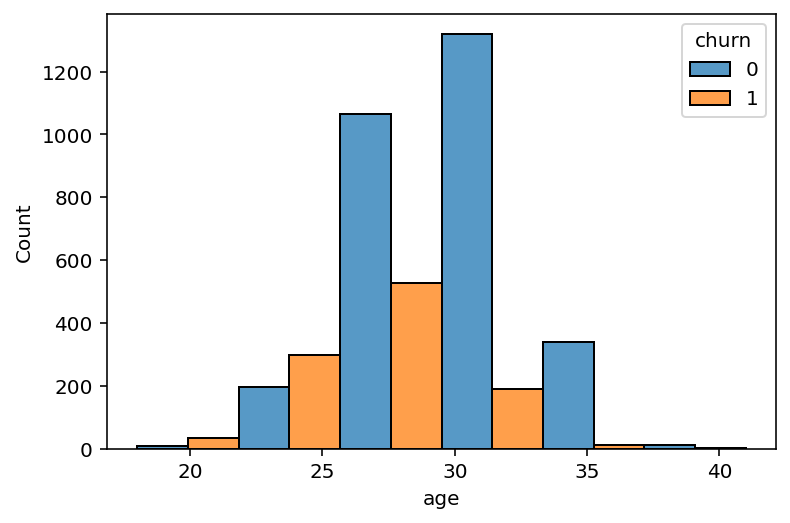

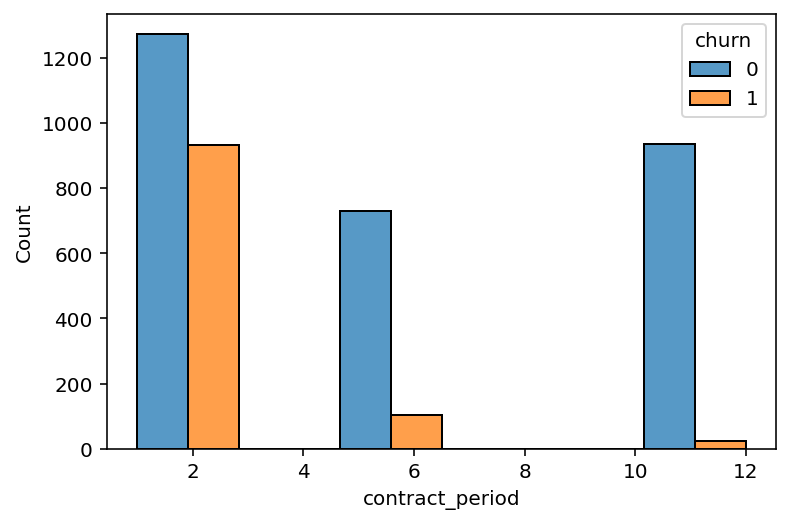

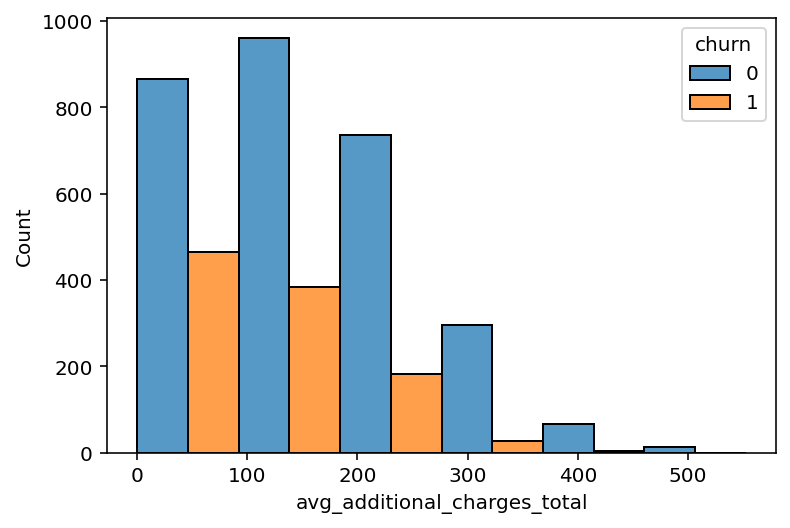

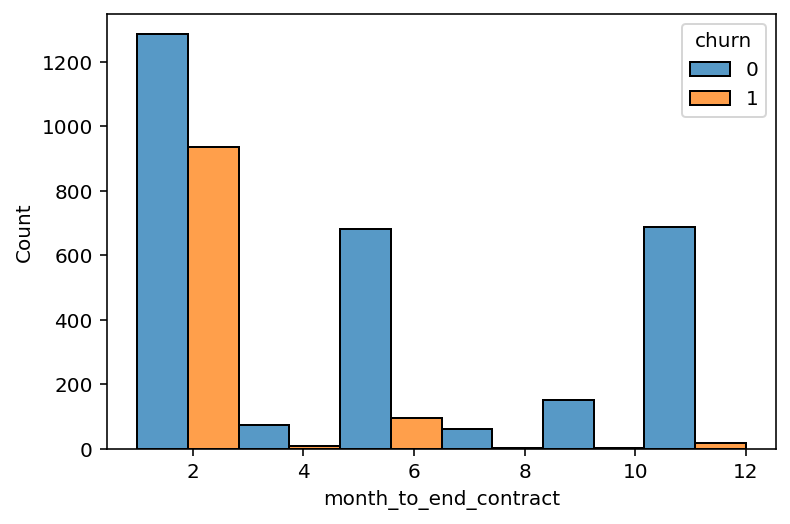

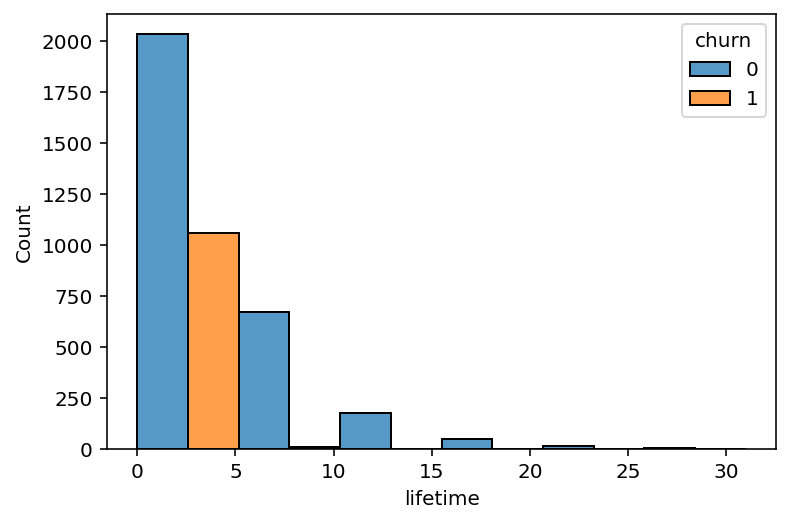

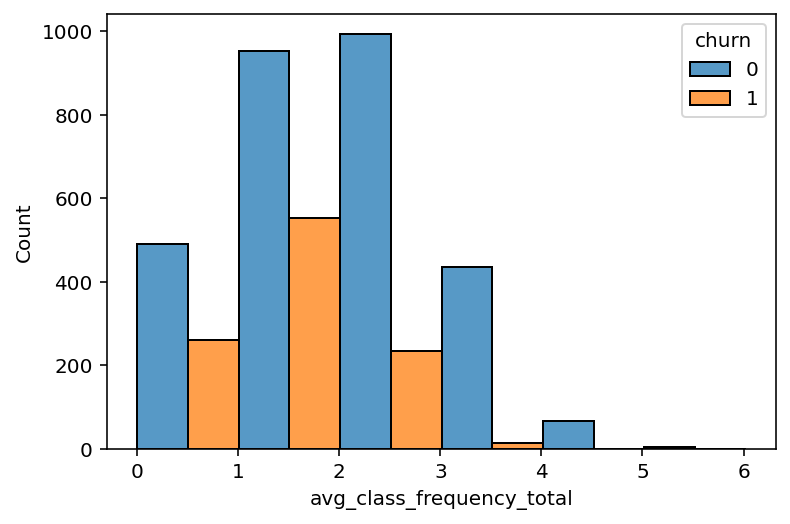

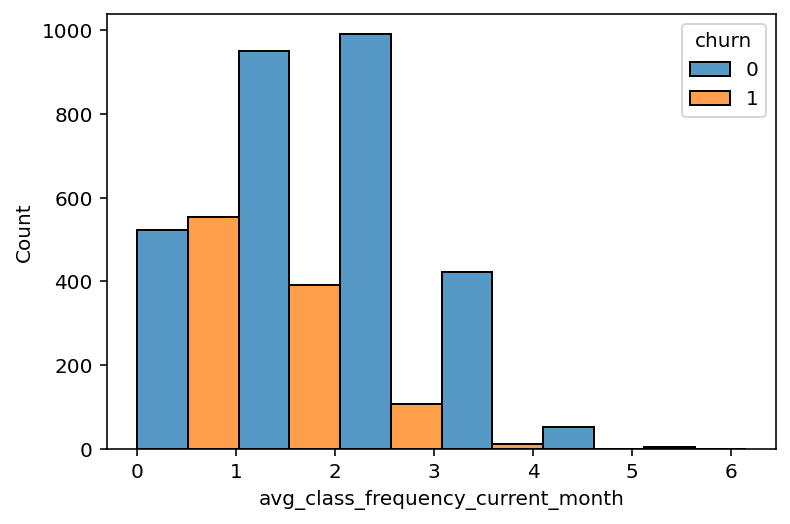

In [10]:
# выведем гистограммы по непрерывным признакам с разбивкой на группы с оттоком и без 

hist_columns = ['age', 'contract_period',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

for feature in hist_columns:
  sns.histplot(data=df, x=feature, hue='churn', multiple='dodge', bins=6)
  plt.show()

По графикам видно, что у некоторых признаков прослеживается явная зависимость оттока от показателей.
Например, у признаков `lifetime` и `contract_period` заметно, что большая часть оттока – с показателем до 5 месяцев.

А вот графики по признакам `age` или `avg_additional_charges_total` показывают, что в обеих группах распределение примерно одинаковое.

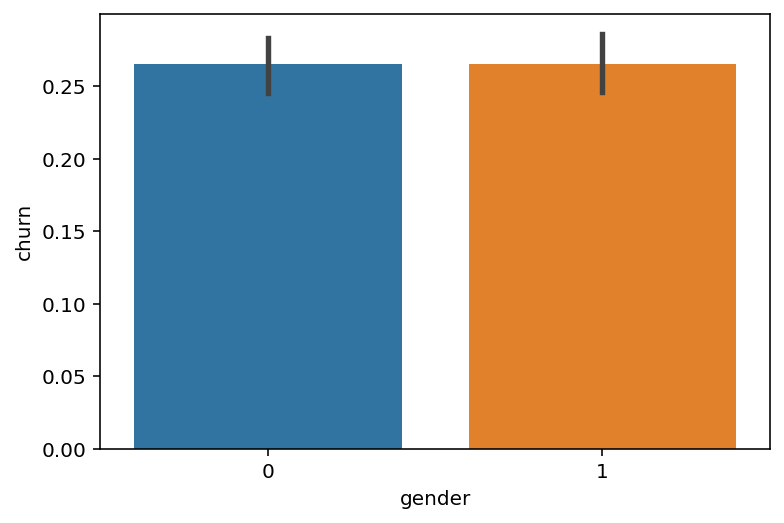

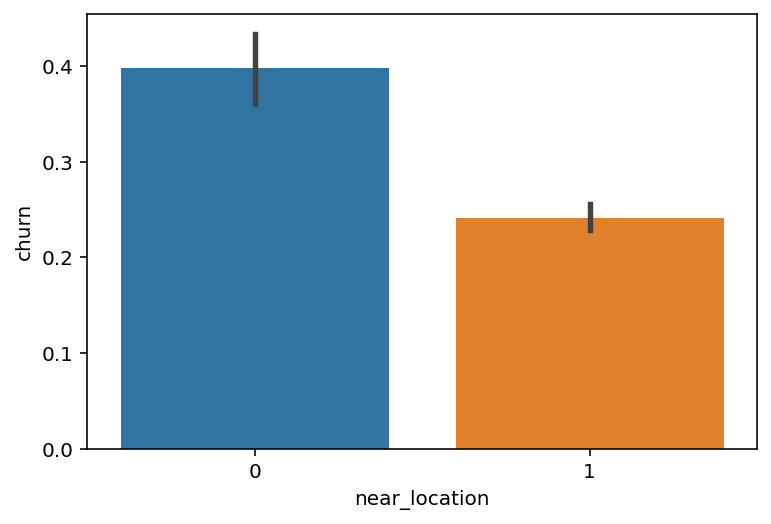

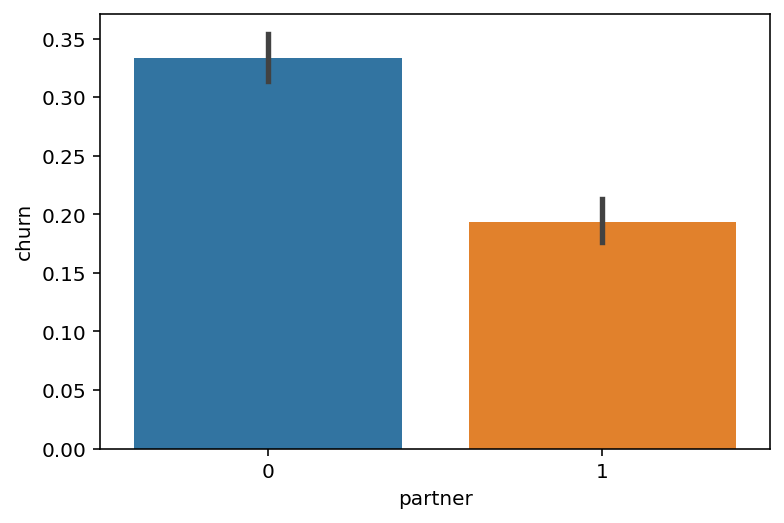

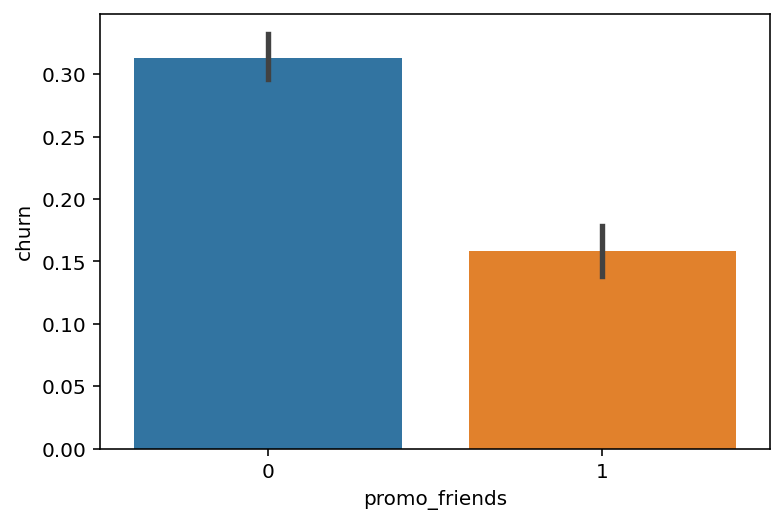

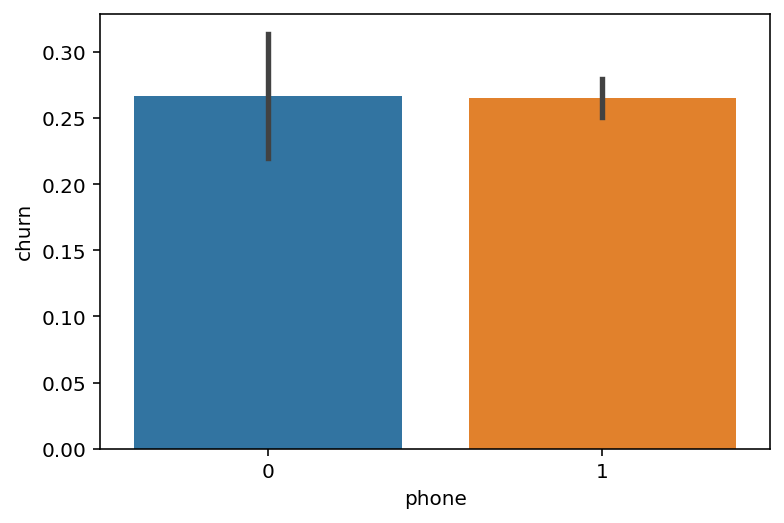

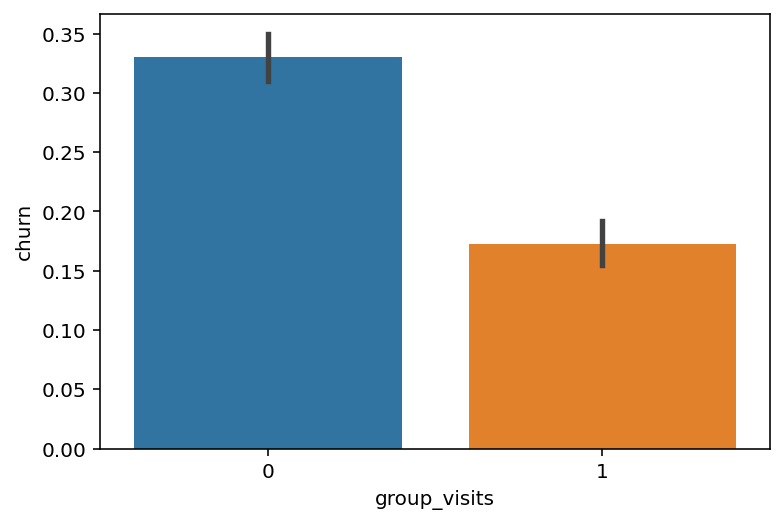

In [12]:
# выведем барплоты по дискретным признакам с разбивкой на группы с оттоком и без

bar_columns = ['gender', 'near_location', 'partner', 'promo_friends',
               'phone', 'group_visits']

for feature in bar_columns:
  sns.barplot(x=feature, y='churn', data=df)
  plt.show()

Графики подтверждают цифры из выводы из таблицы средних значений.

По некоторым положительным признакам явно прослеживается более низкий отток (например, `promo_friends` или `group_visits`).

А другие признаки не подтверждают корреляции с оттоком (например, `gender` или `phone`).

### Построим матрицу корреляций:

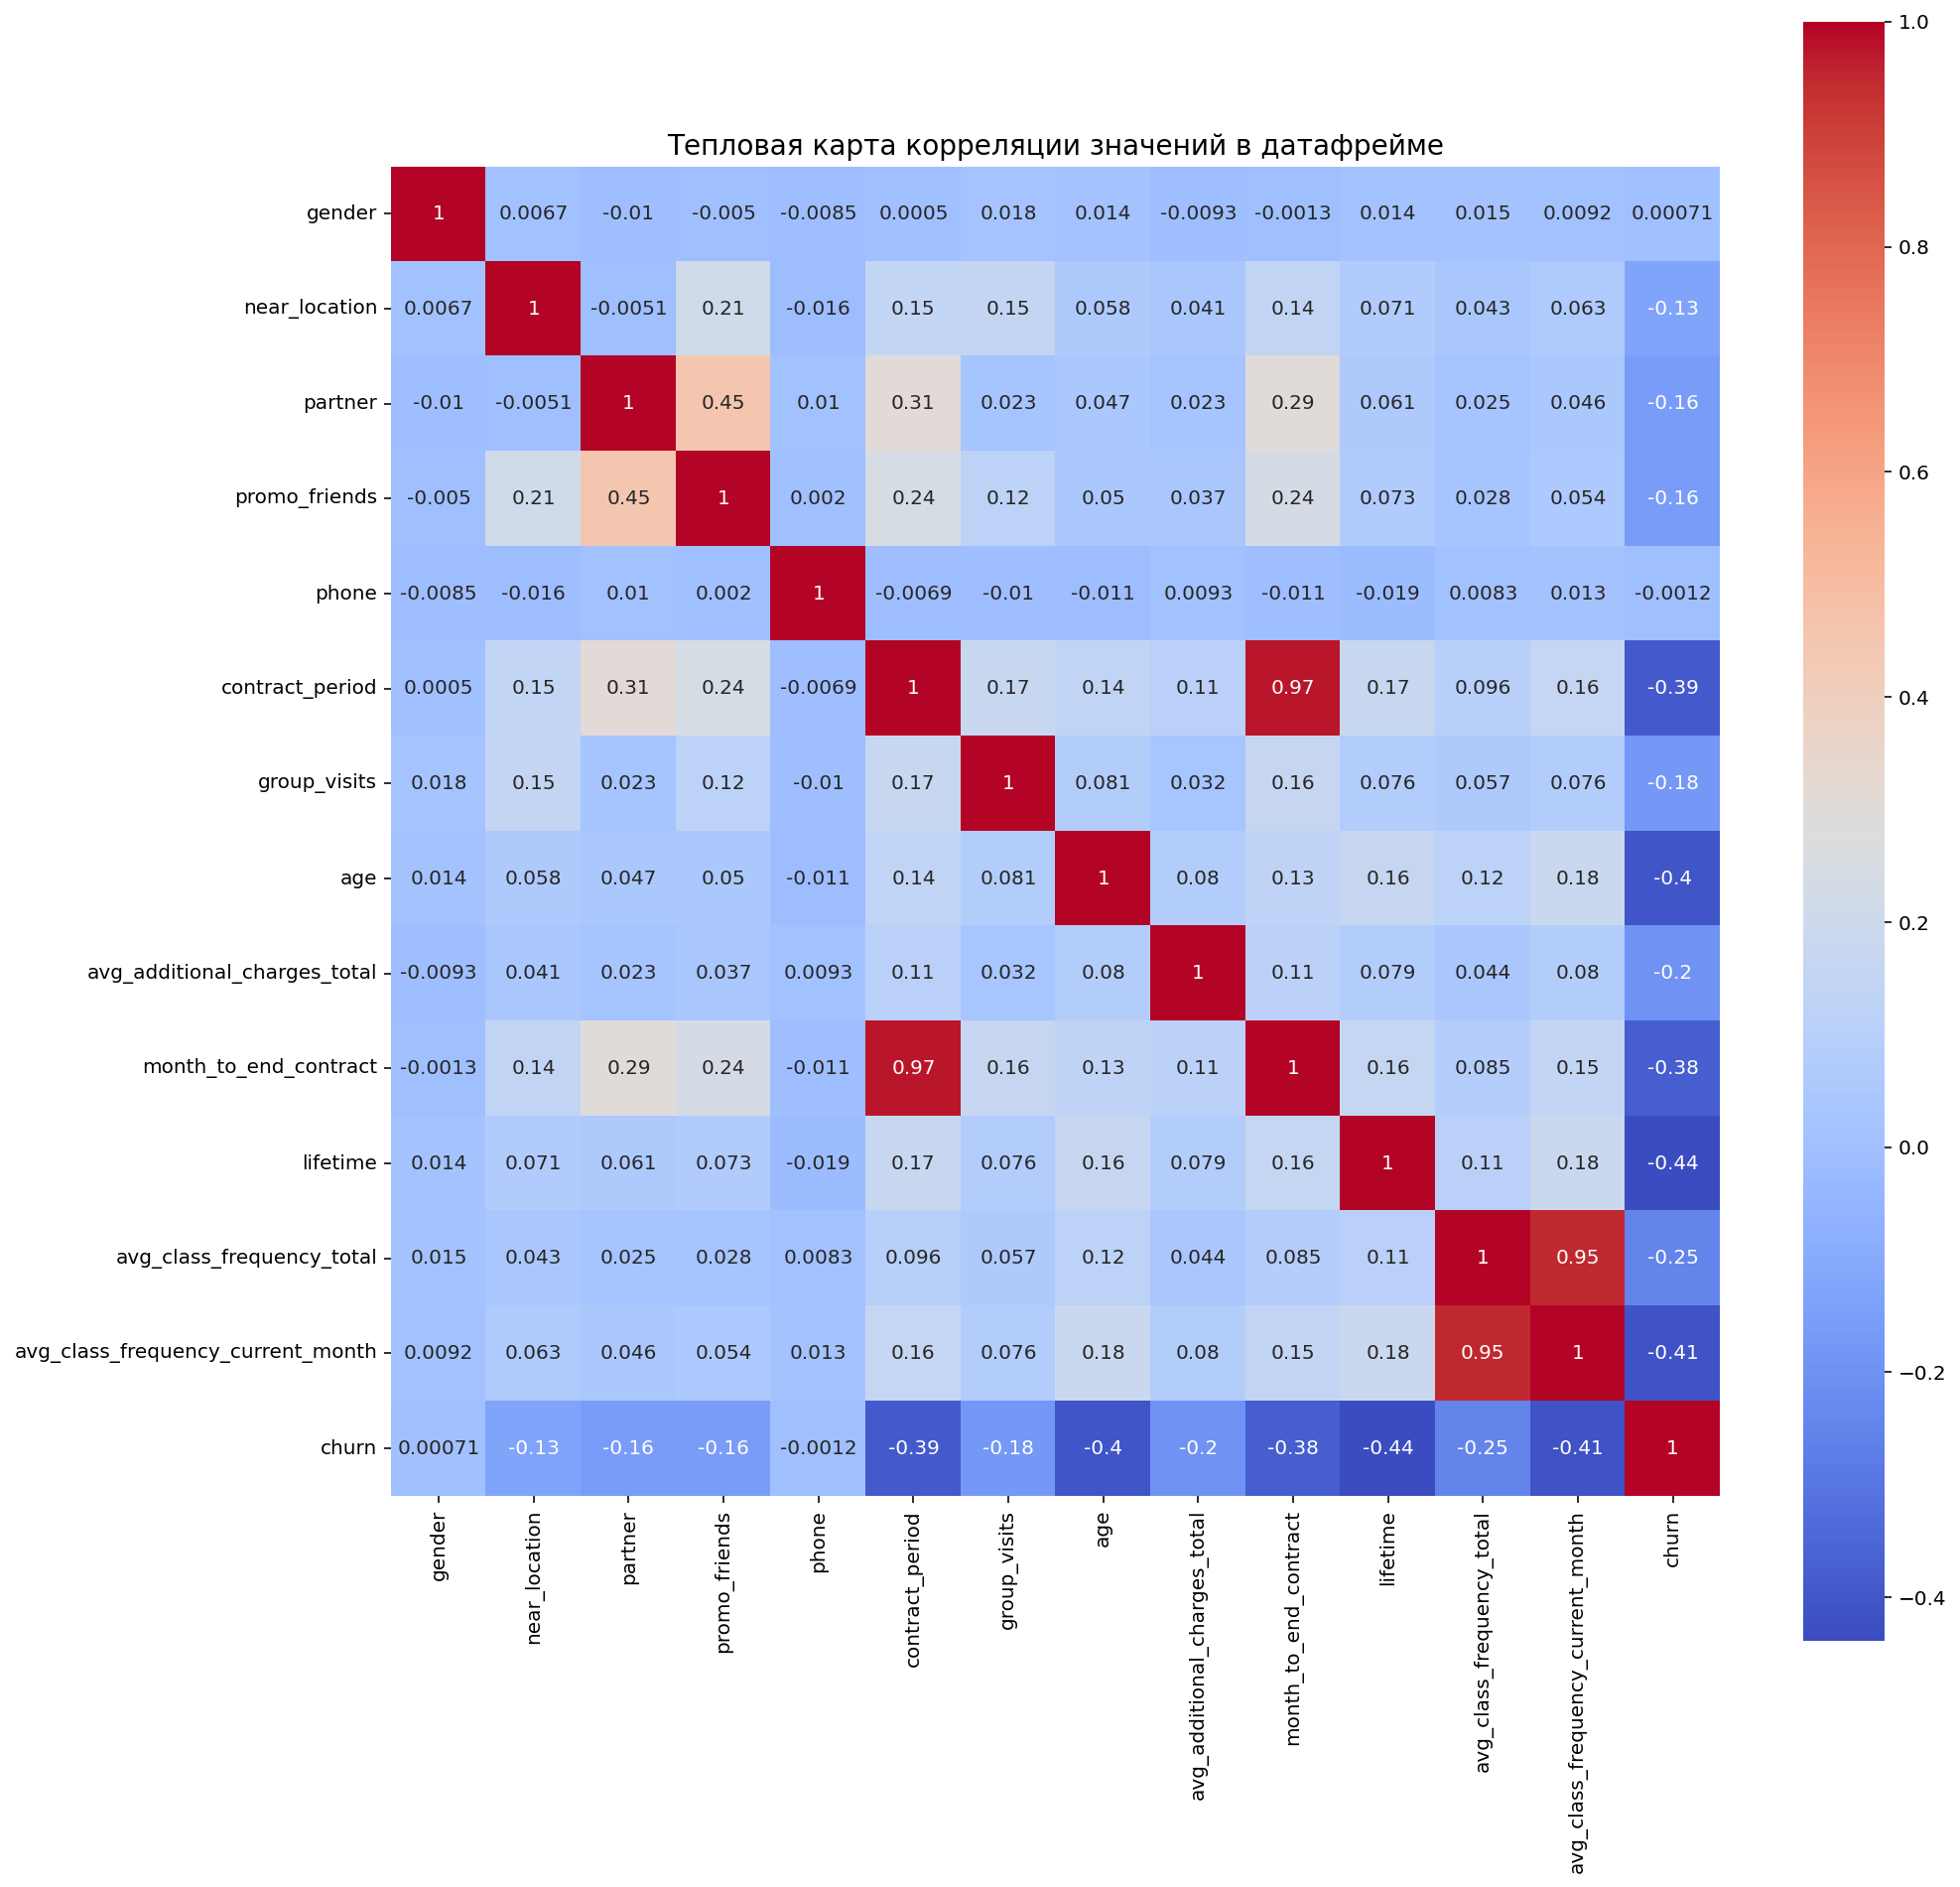

In [13]:
# построим и отобразим тепловую матрицу корреляций
cm = df.corr()

plt.figure(figsize=(15,15))
plt.title('Тепловая карта корреляции значений в датафрейме', fontsize=14)

sns.heatmap(cm, square=True, annot=True, cmap='coolwarm');

Судя по матрице корреляций, нет признаков, с высокой вероятностью сообщающих правильный ответ – с целевой переменной не коррелирует ни один признак. Есть умеренная корреляция у пар `promo_friends`-`partner`, `contract_period`-`partner` и нескольо слабых корреляций по многим парам. 

Зато есть несколько сильно скореллированных между собой признаков: `contract_period` и `month_to_end_contract`, `avg_class_frequency_total` и `avg_class_frequency_current_month` – они могут негативно повлиять на обучение линейной модели, если не использовать регуляризацию (например, подойдет `Lasso regression`).

### Вывод по шагу

Мы рассмотрели средние показатели по всему датафрейму и матрицу корреляций, получили базовую информацию по распределению признаков. Эта информация даже без построения моделей позволяет сделать некоторые выводы относительно того, что может влиять на отток клиентов.


---

## Шаг 3. Модель прогнозирования оттока пользователей

### Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце


In [14]:
# разделим данные на признаки и целевую переменную
X = df.drop(['churn'], axis=1) 
y = df['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучим модель на train-выборке логистической регрессией

In [15]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0) 

# обучим модель
lr_model.fit(X_train_st, y_train) 

# сделаем прогнозы обученной моделью
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

### Обучим модель на train-выборке случайным лесом

In [16]:
# зададим алгоритм для модели случайного леса
rf_model = RandomForestClassifier(random_state=0) 

# обучим модель
rf_model.fit(X_train, y_train) 

# сделаем прогнозы обученной моделью
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

### Оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке и сравним модели

Определим функцию, которая будет выводить метрики:


In [17]:
# задаем функцию вывода метрик
def print_all_metrics(y_test, y_pred, y_proba, title=''):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, y_pred)))

In [18]:
# выведем метрики классификации обеих моделей
print_all_metrics(y_test, lr_predictions, lr_probabilities,
                  title='Метрики для модели логистической регрессии:')
print('')
print_all_metrics(y_test, rf_predictions, rf_probabilities,
                  title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


### Вывод по шагу

На основании расчитанных метрик обе модели прогнозируют большой процент верных ответов – 92%. 

Однако **у модели линейной регрессии значения метрик точности и полноты чуть выше**, чем у модели случайным лесом. Поэтому эта модель видится более предпочтительной для использования в прогнозах.

---

## Шаг 4. Кластеризация пользователей

Проведем кластеризацию объектов (пользователей).

### Стандартизируем данные

In [19]:
# преобразуем набор данных нормализатором на датасете без целевой переменной
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:5]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121,  0.16160501,
        -0.19332863, -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  1.83194105,
         0.87368001,  0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.79287273,
        -0.46008079, -0.02049263, -0.02901851],
       [-1.0207145 ,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
         1.60882159,  1.19403206,  1.17120844, -0.87472237,  1.83194105,
        -0.46008079,  1.36465509,  1.51045005],
       [ 0.97970588,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
        -0.8092194 , -0.83749845, -0.97737548,  0.5336998 , -0.79287273,
        -0.19332863, -0.78707638, -0.61454183]])

На выходе получили преобразованные таблицы объект-признак для обучающего и валидационного набора. И уже их будем применять для обучения и прогнозирования.

### 4.2 Построим матрицу расстояний и нарисуем дендрограмму

Используем функцию `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму.

In [20]:
# сохраняем в переменной linked таблицу связок между объектами
linked = linkage(X_sc, method = 'ward')

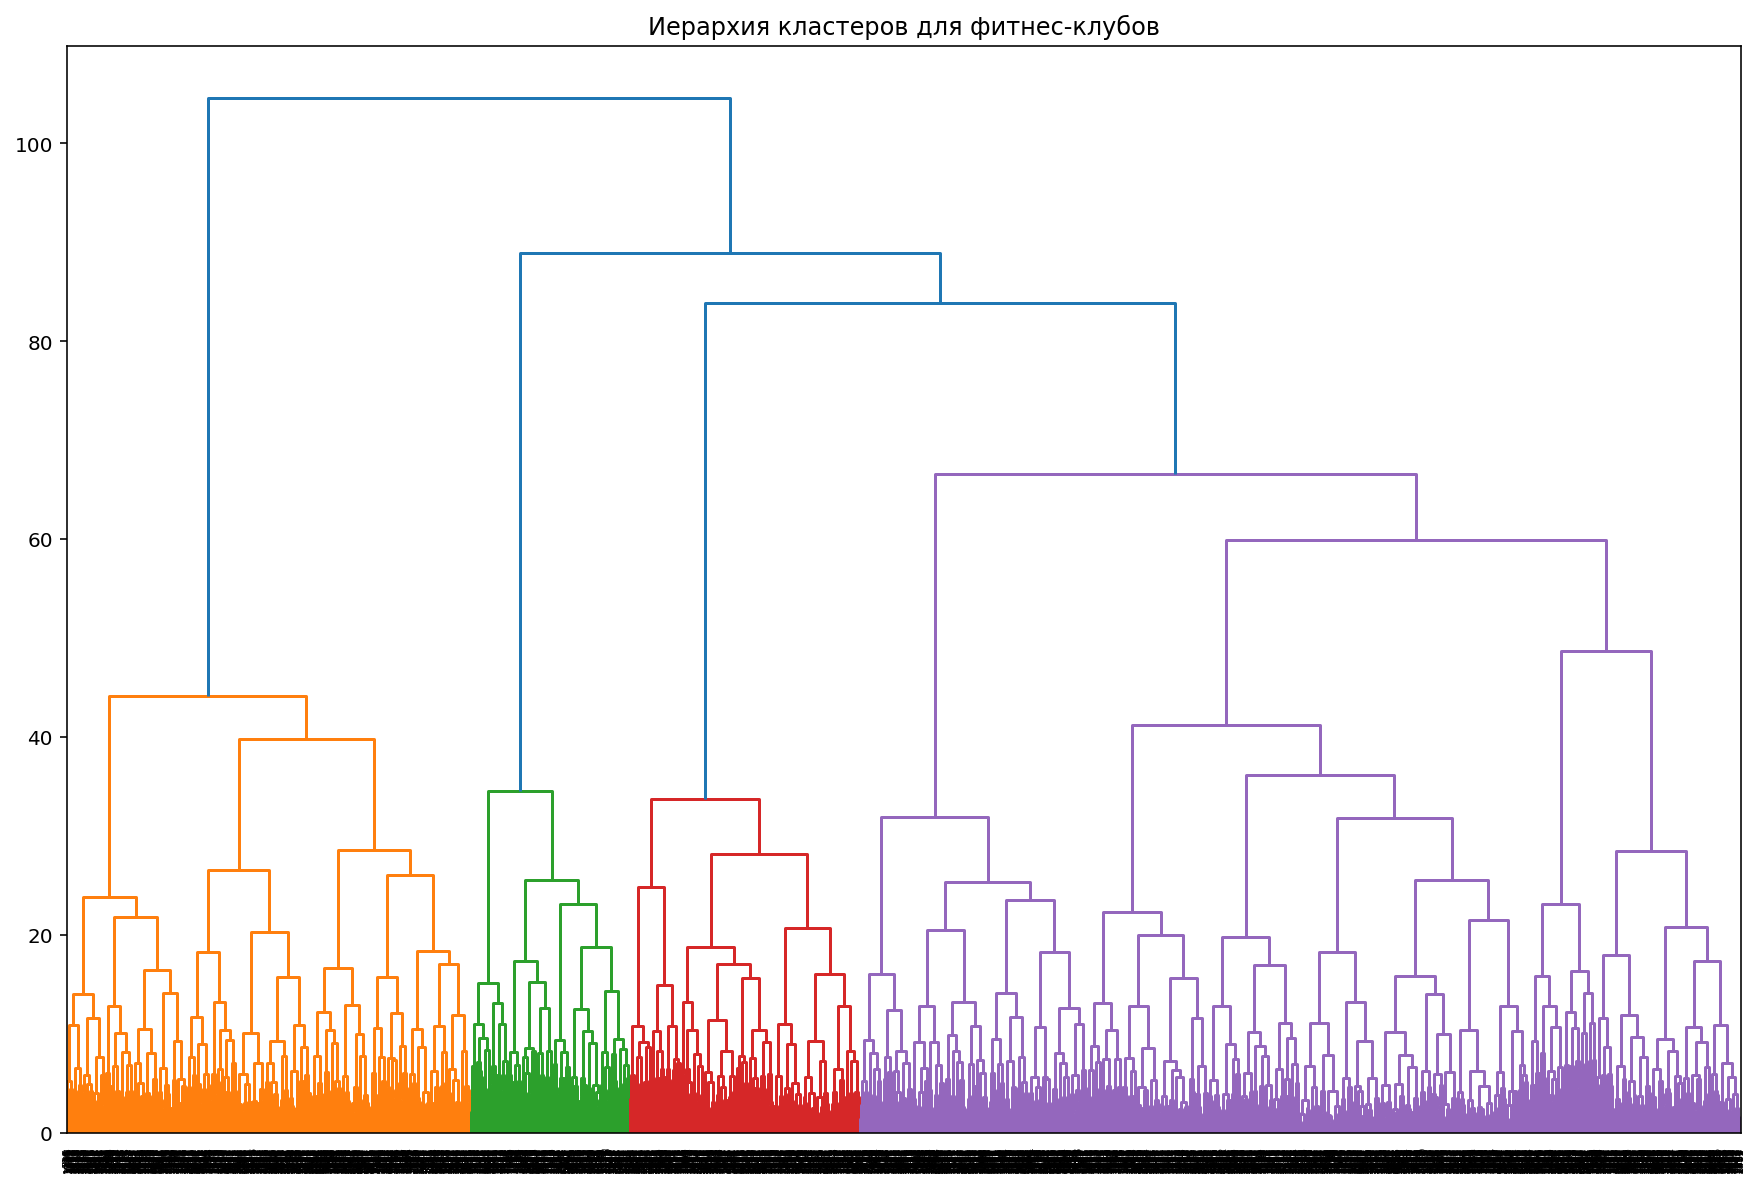

In [21]:
# выведем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеров для фитнес-клубов')
plt.show()

При построении дендрограммы без учета целевой переменной получаем число кластеров 4 (по цветам веток), а если подняться на уровень y=50, то по числу пересечений веток можно выделить 6 кластеров.

Возьмем среднее между этими цифрами число кластеров – 5 и используем его, как указано в задании.

### Обучим модель кластеризации

Используем алгоритм K-Means и спрогнозируем кластеры клиентов.

In [22]:
# зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)

# спрогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле датасета
X['cluster'] = labels

Посмотрим на средние значения признаков для кластеров.


In [23]:
# выводим статистику по средним значениям наших признаков по кластеру
X.groupby('cluster').mean().T

cluster                                0      1      2      3      4
gender                              0.50   0.52   0.50   0.49   0.56
near_location                       0.96   0.86   0.00   1.00   0.98
partner                             0.78   0.47   0.46   0.35   0.36
promo_friends                       0.57   0.31   0.08   0.24   0.23
phone                               1.00   0.00   1.00   1.00   1.00
contract_period                    10.89   4.79   2.35   1.95   2.67
group_visits                        0.54   0.43   0.22   0.34   0.47
age                                29.98  29.30  28.48  28.17  30.13
avg_additional_charges_total      160.76 143.96 135.46 131.62 161.66
month_to_end_contract               9.95   4.48   2.20   1.86   2.46
lifetime                            4.74   3.92   2.81   2.44   4.90
avg_class_frequency_total           1.98   1.85   1.66   1.25   2.85
avg_class_frequency_current_month   1.97   1.72   1.48   1.01   2.85

In [24]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

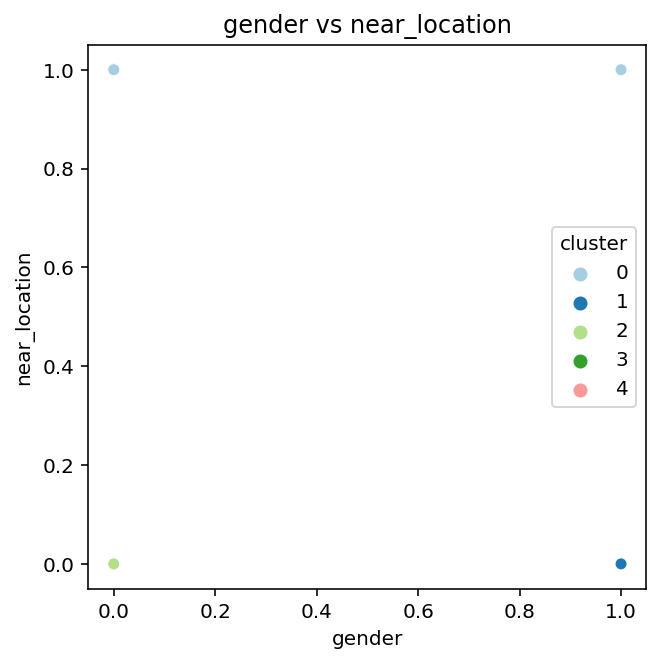

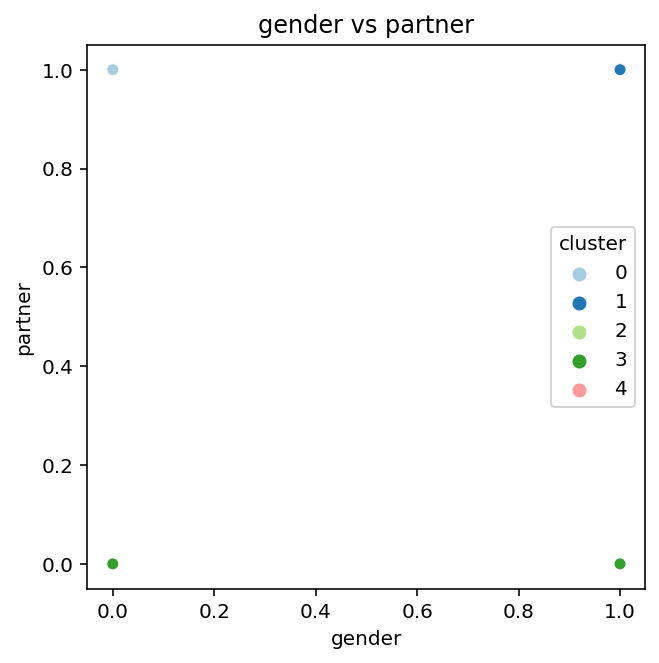

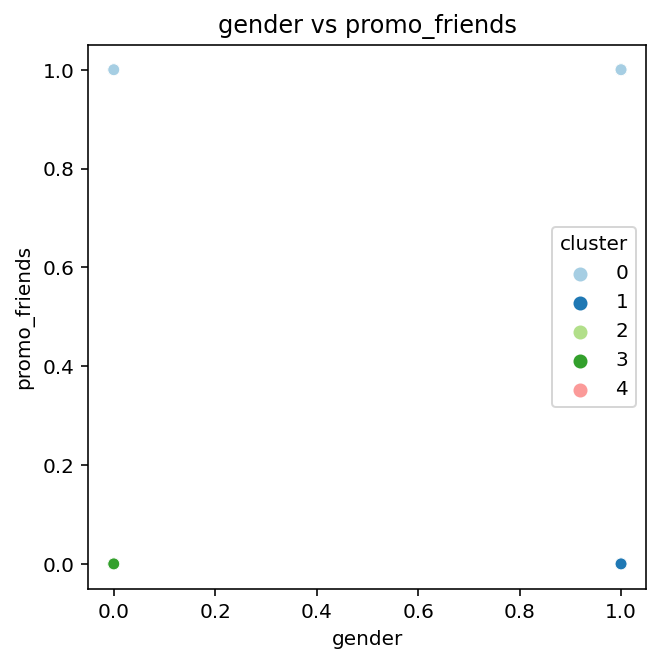

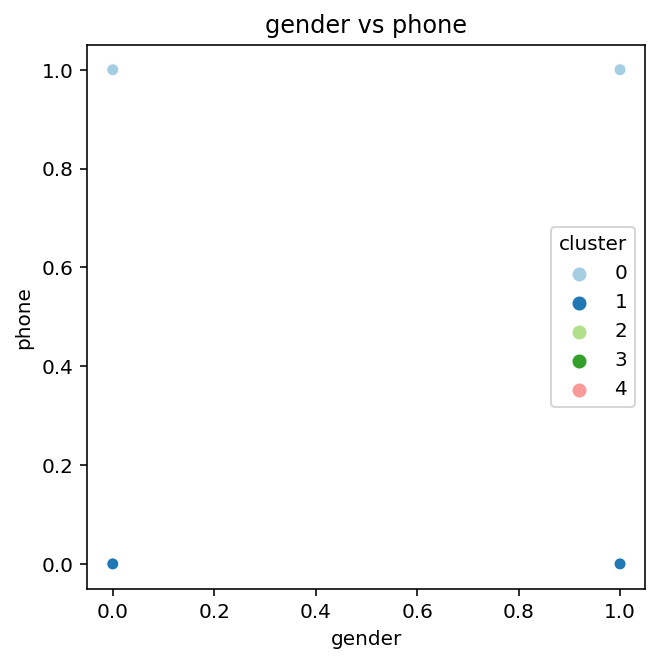

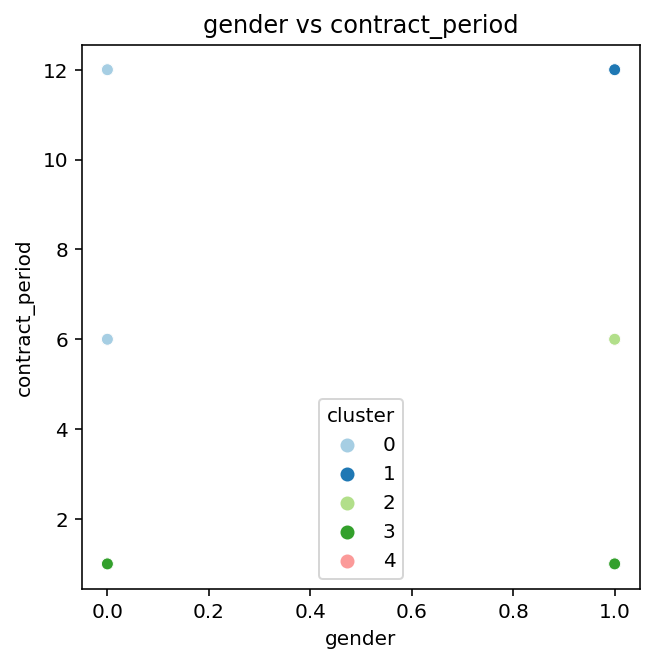

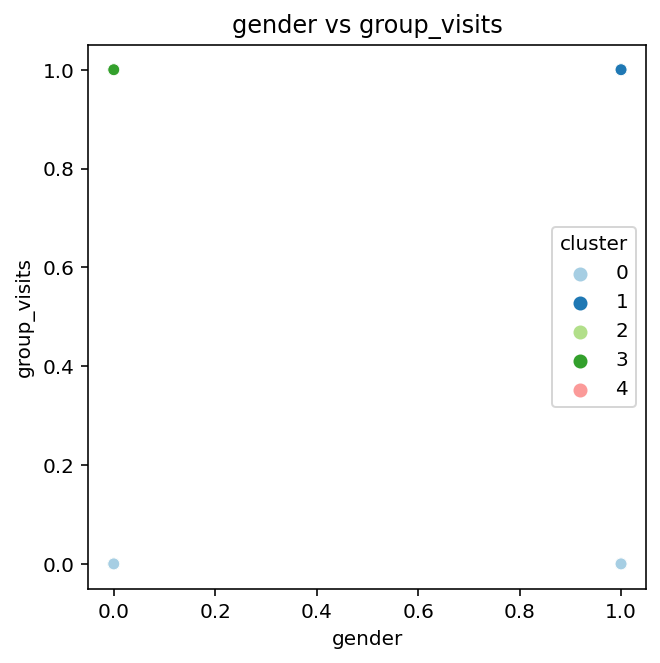

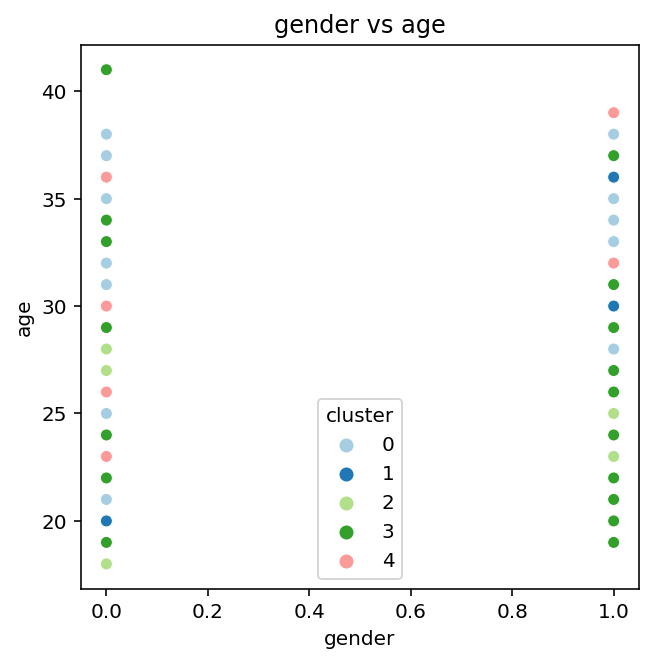

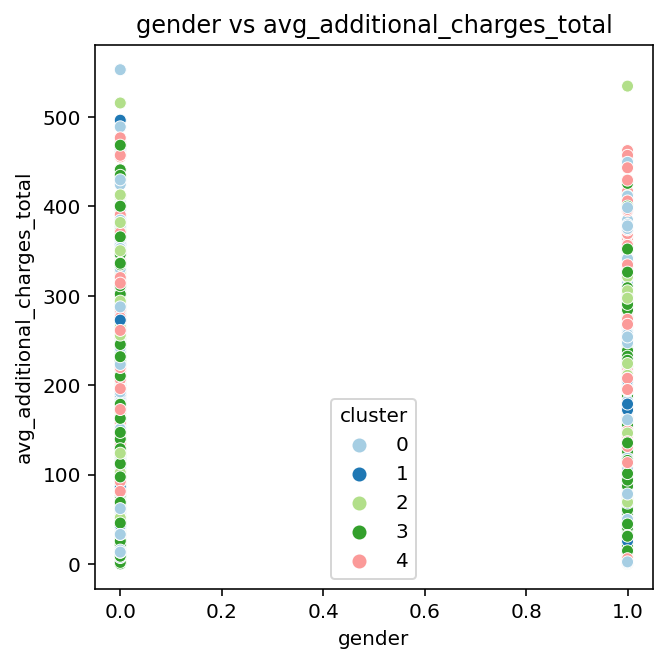

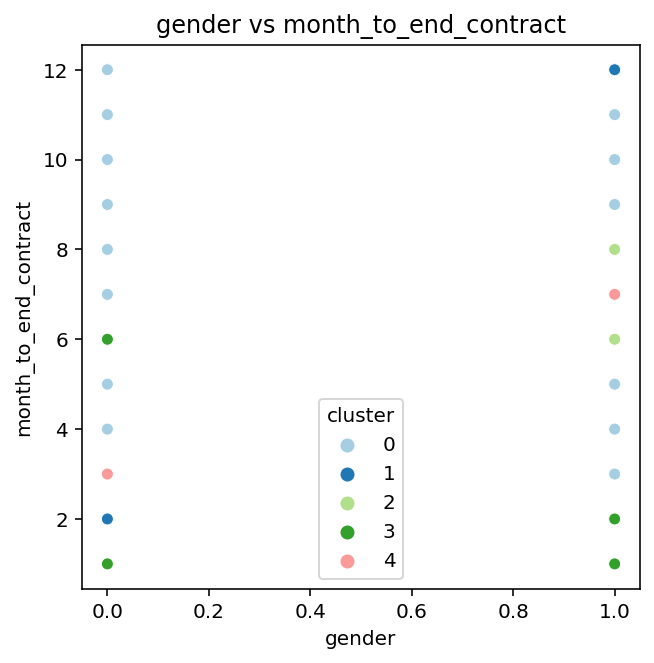

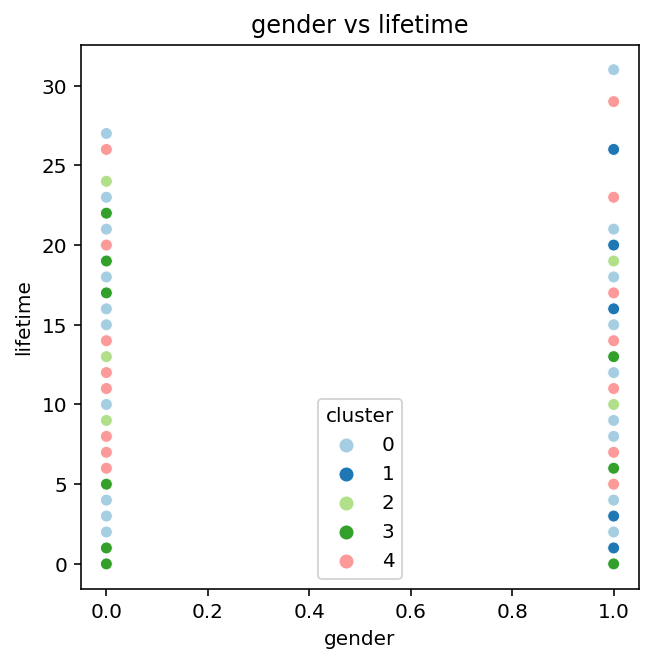

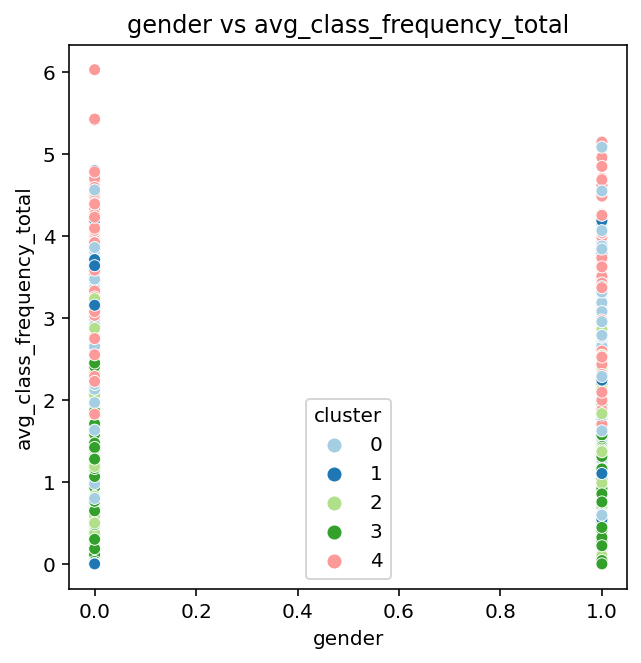

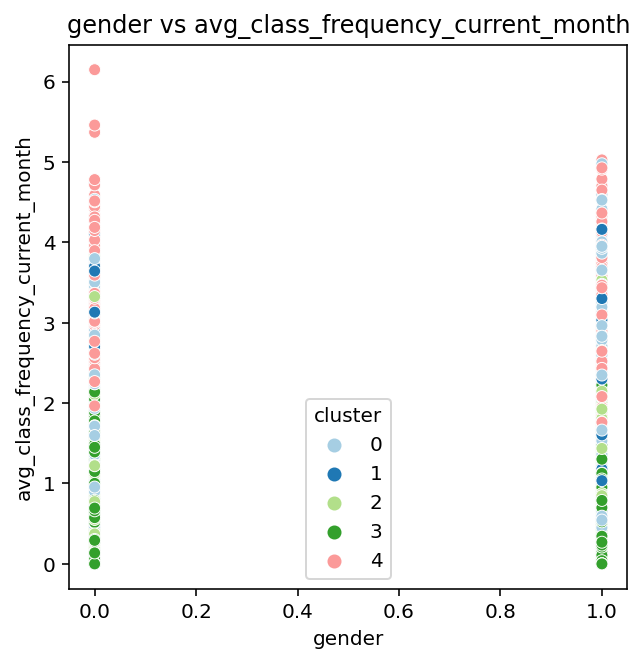

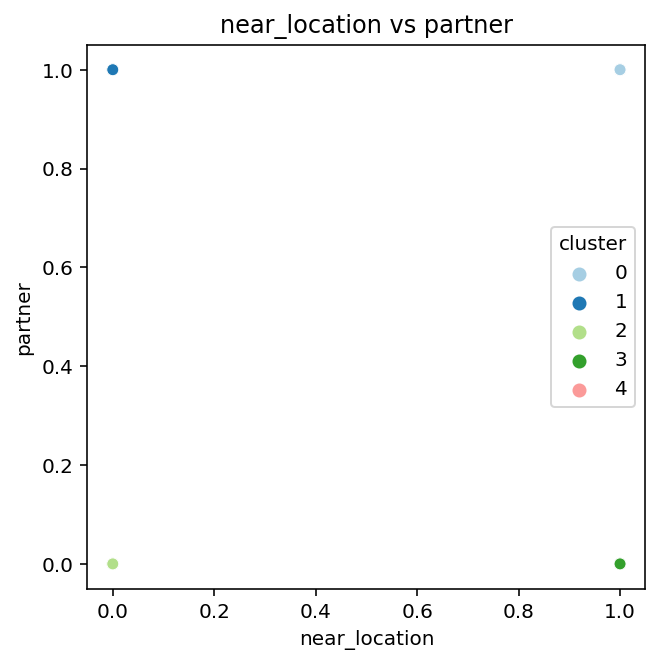

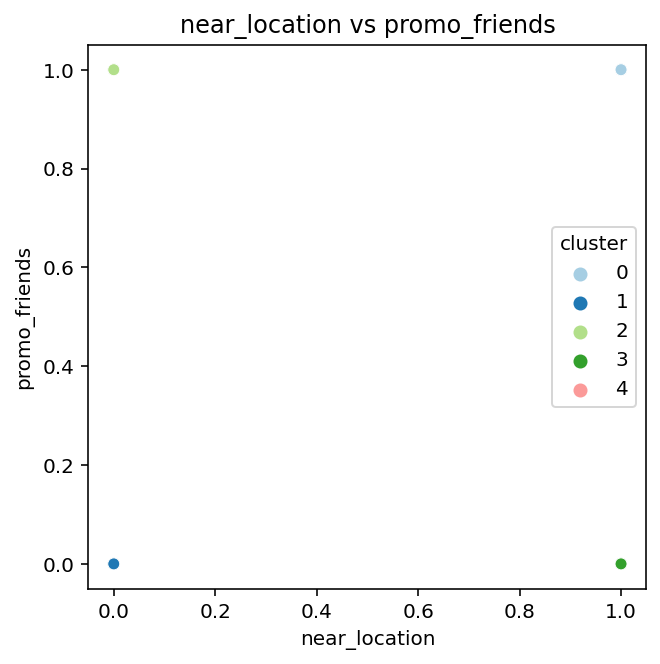

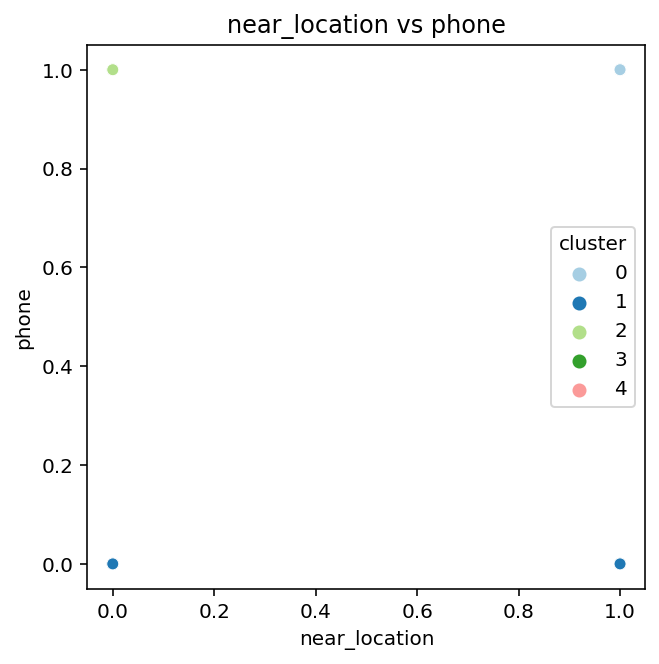

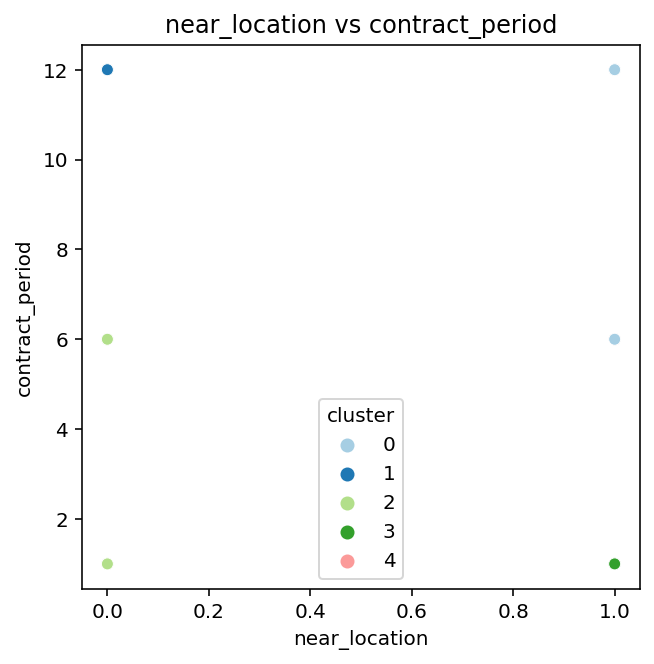

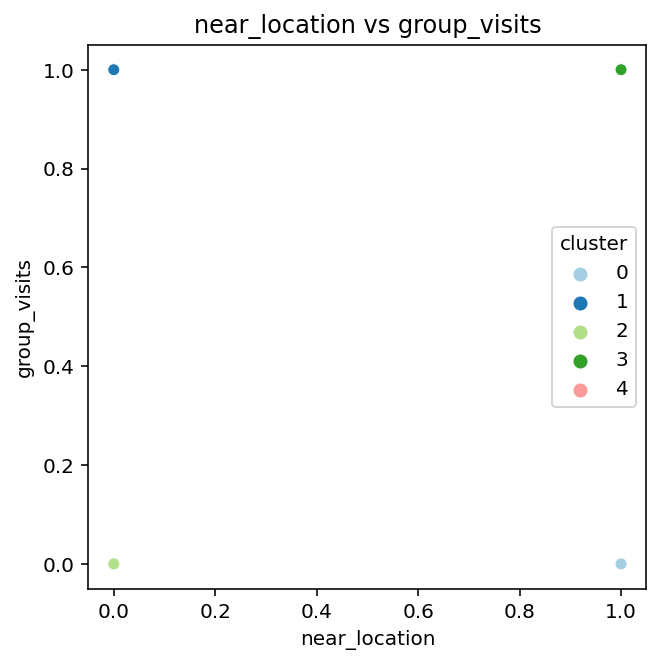

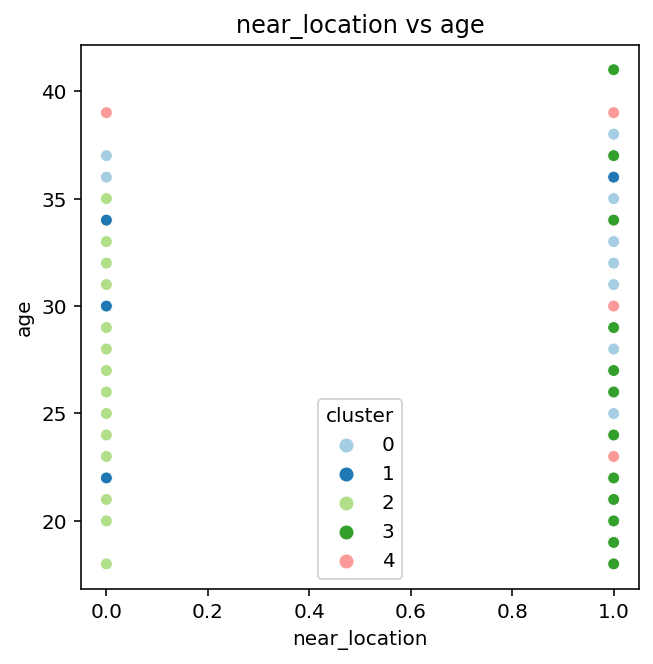

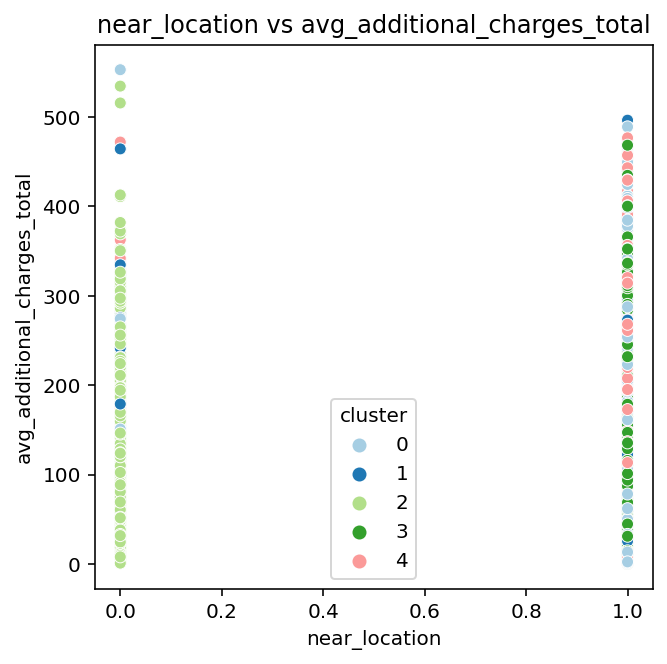

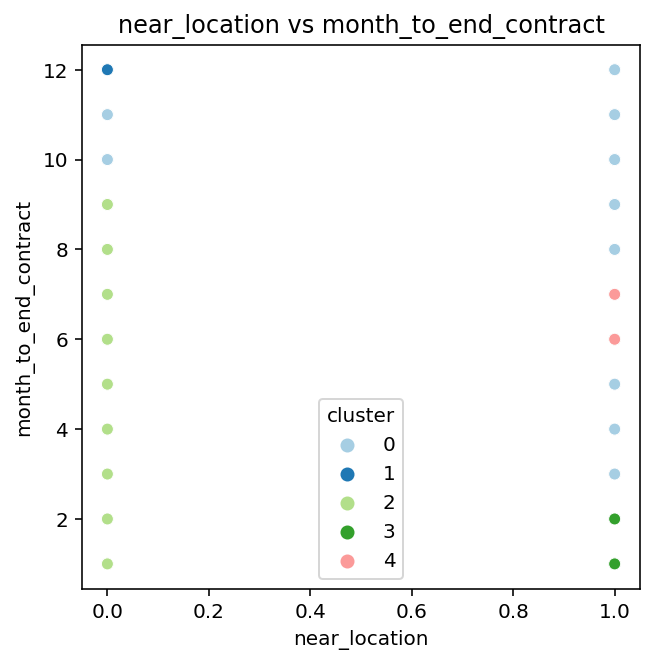

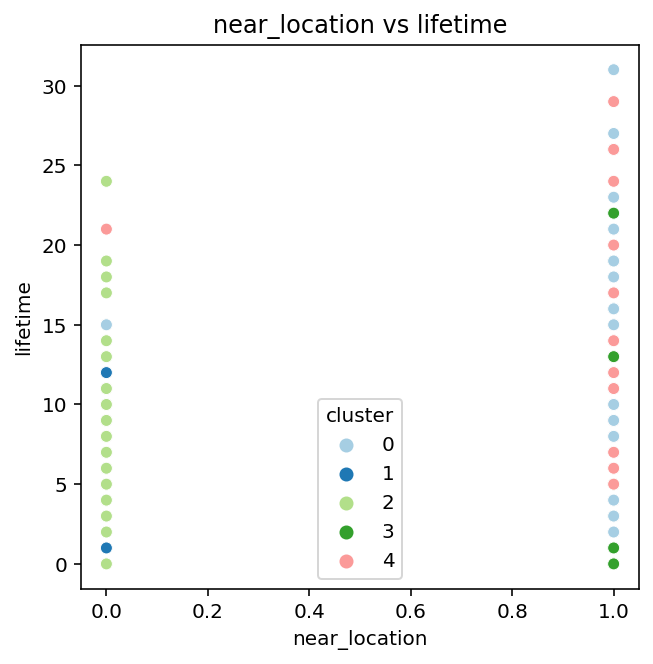

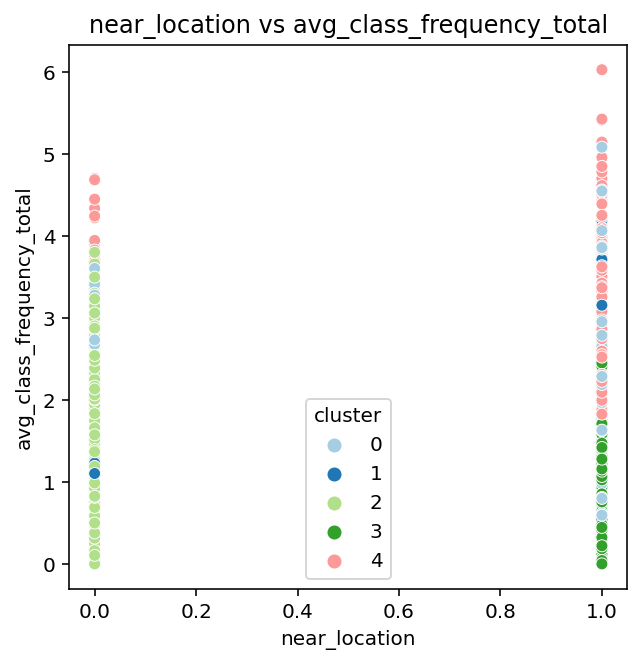

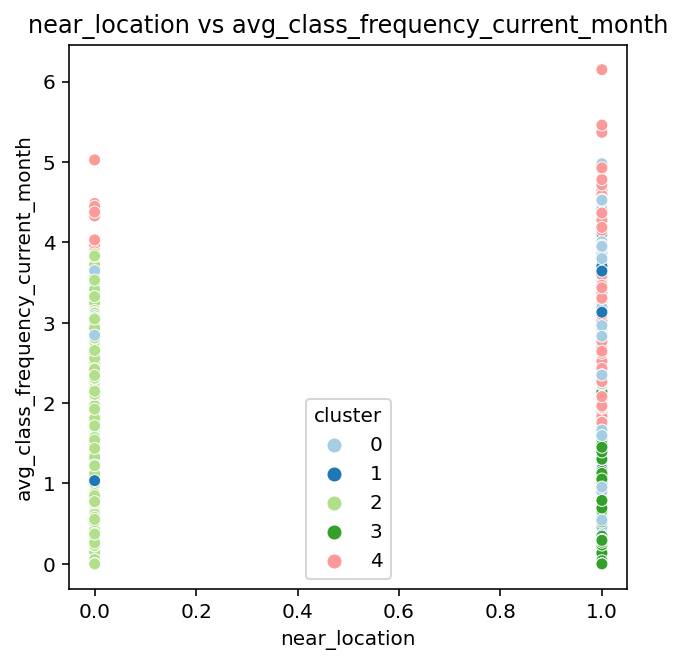

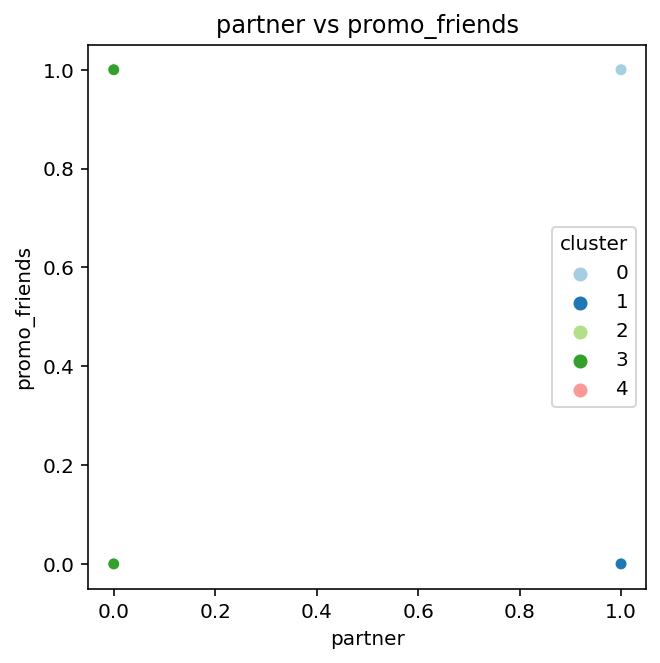

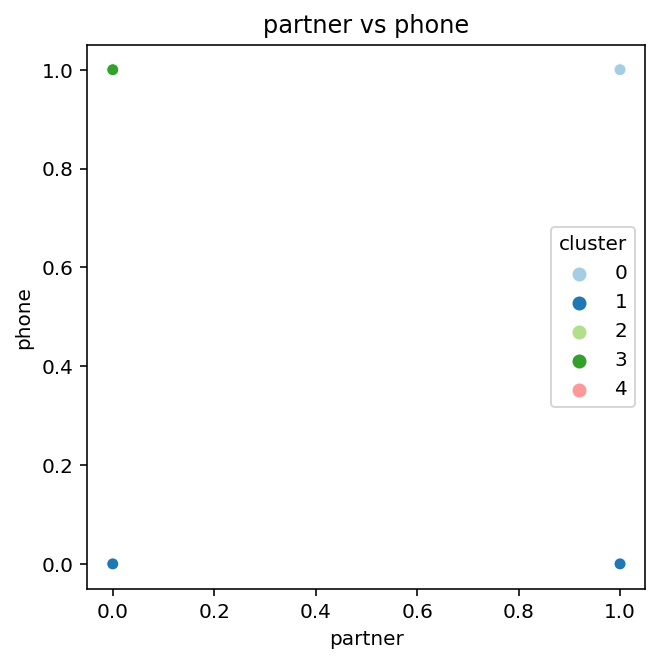

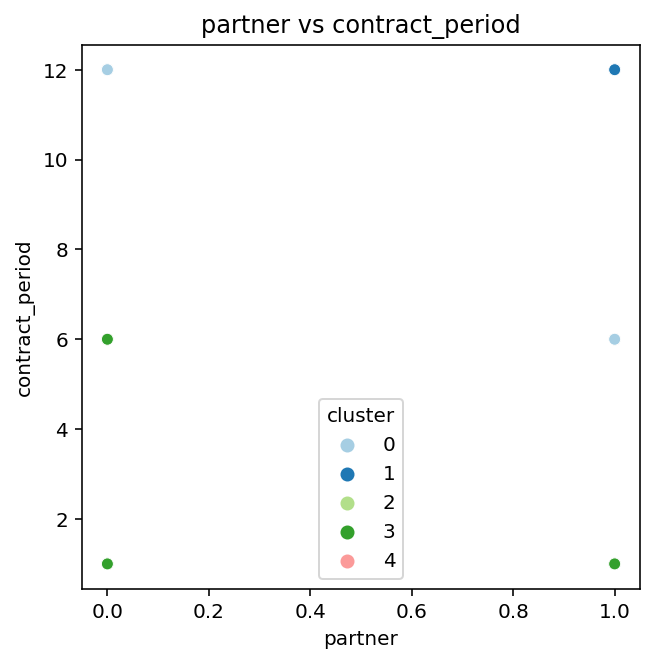

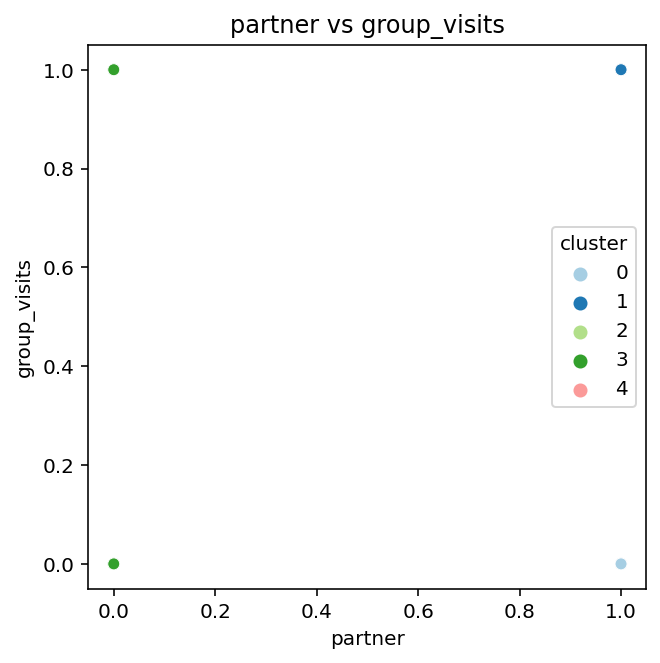

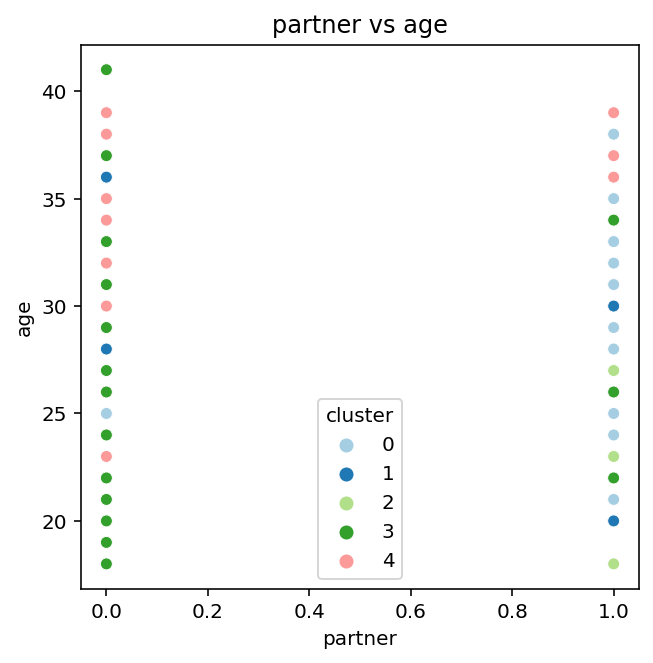

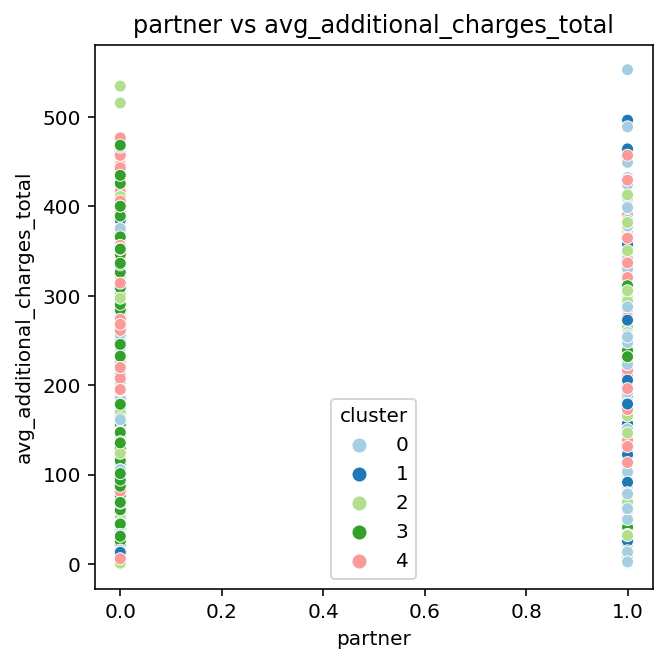

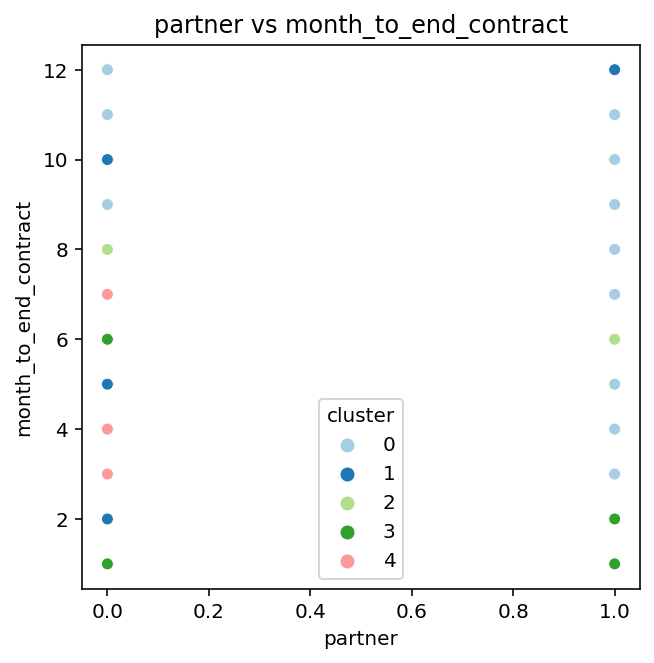

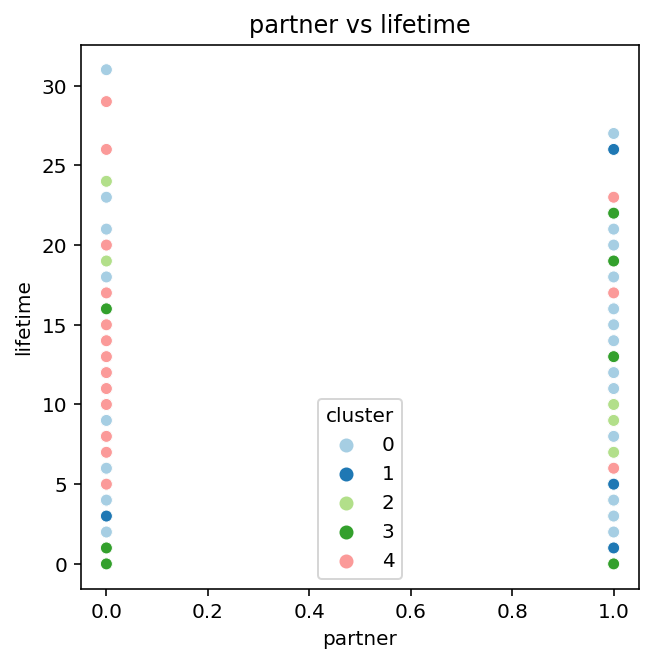

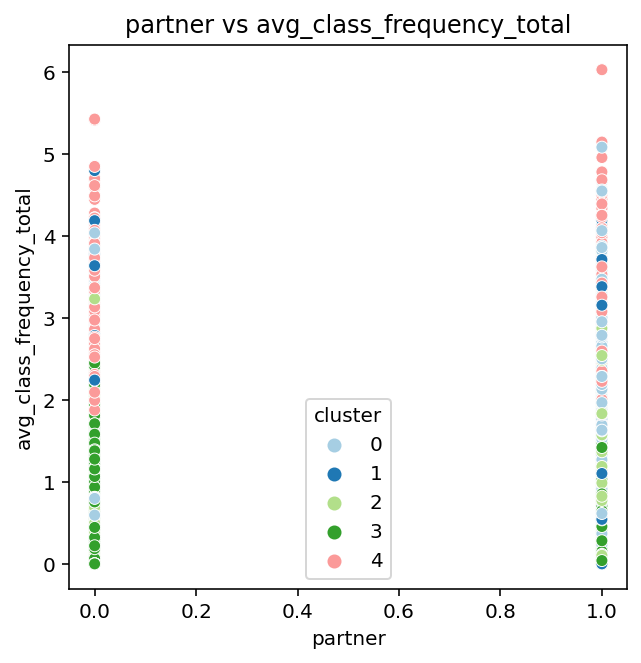

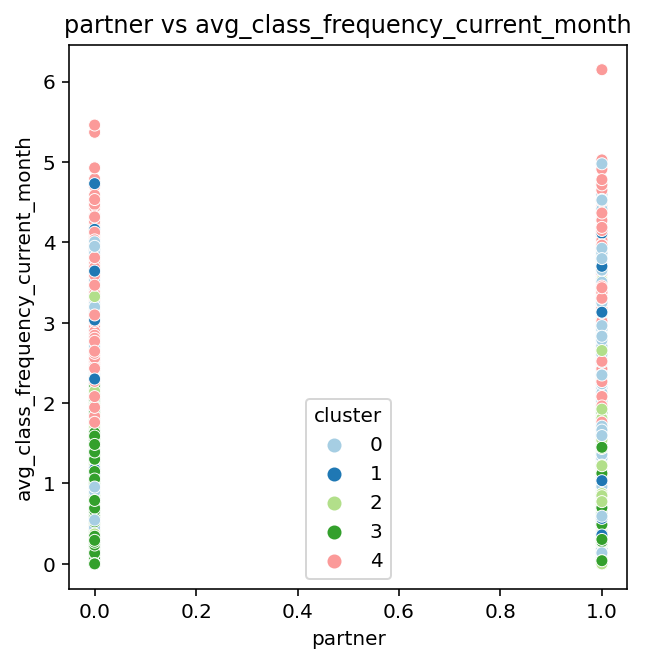

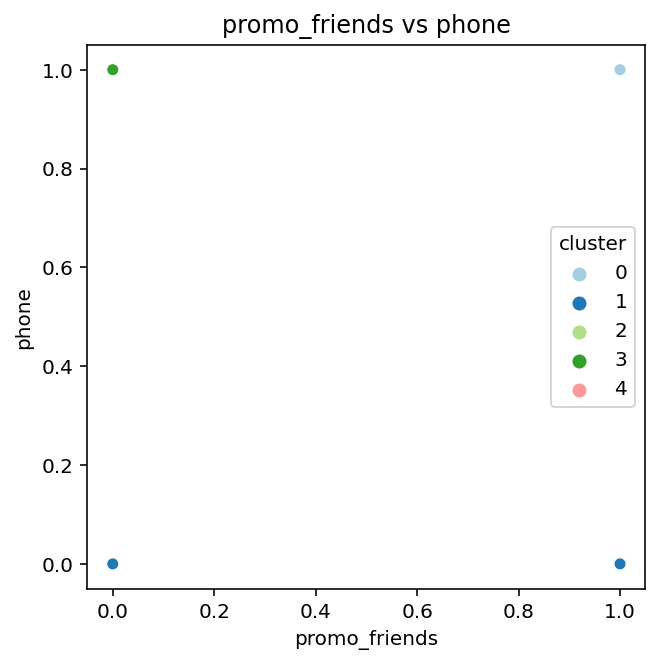

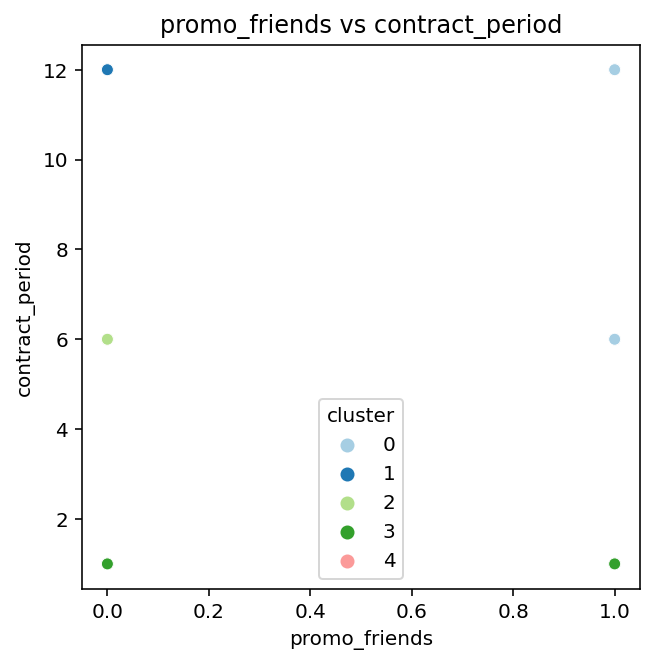

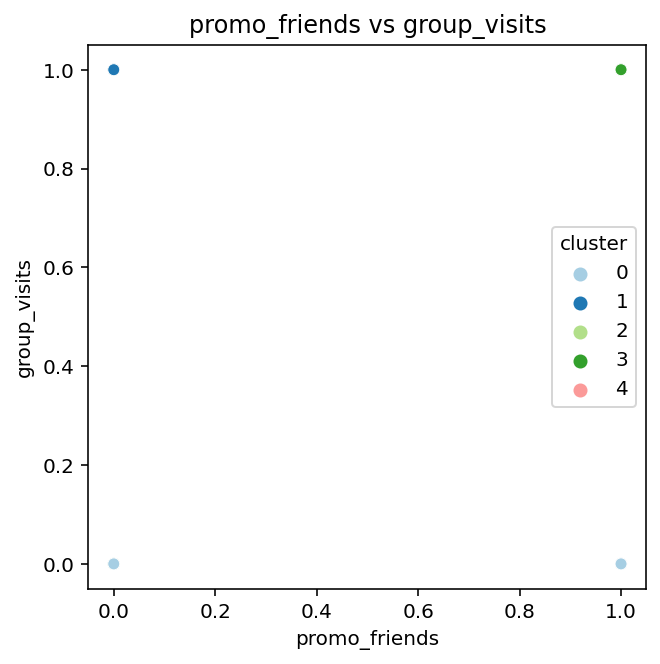

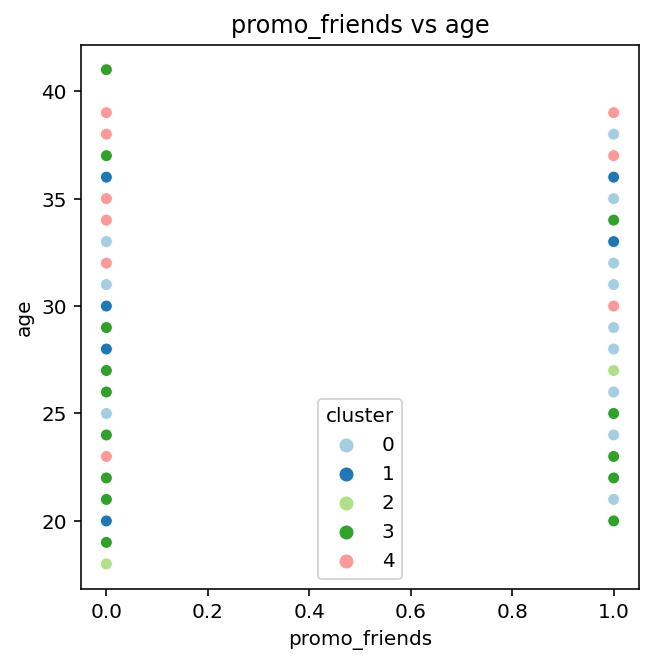

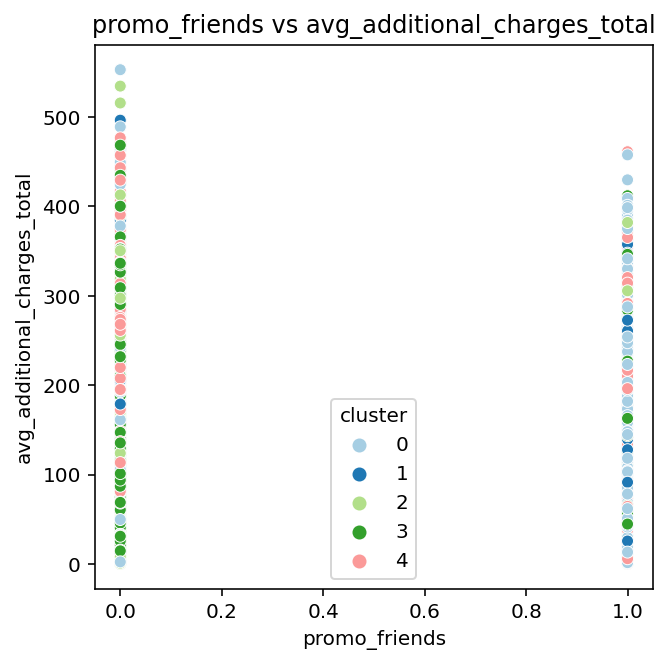

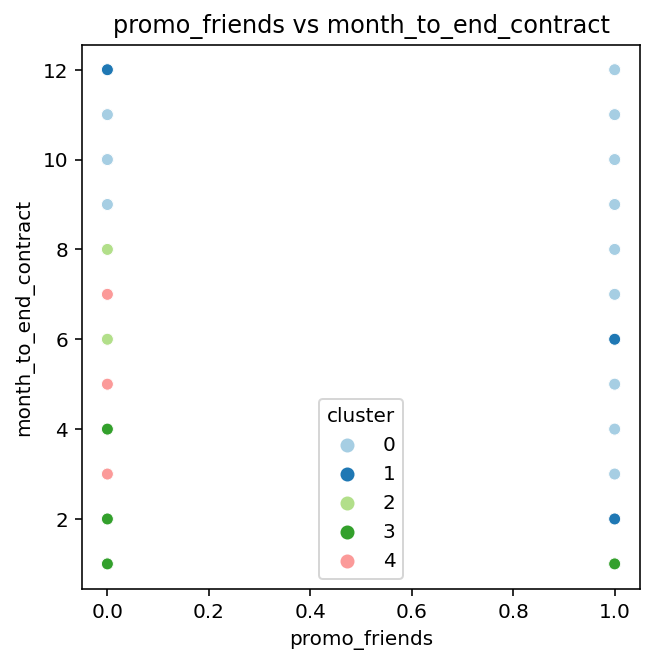

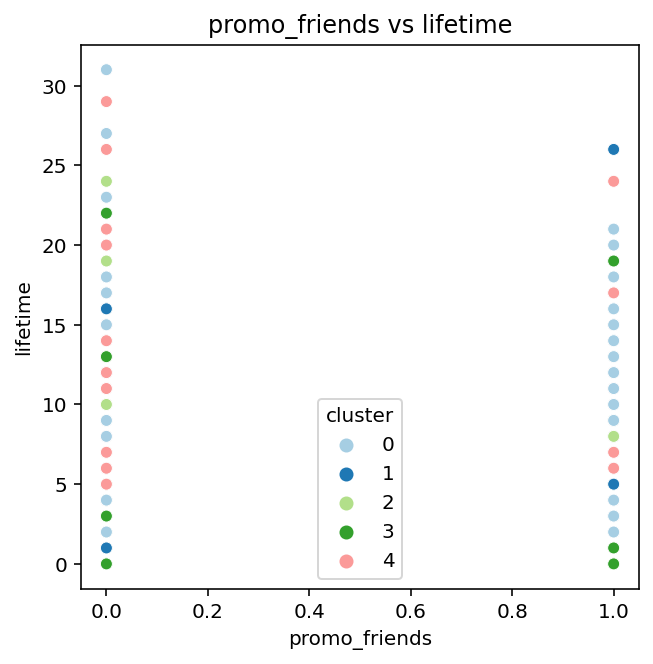

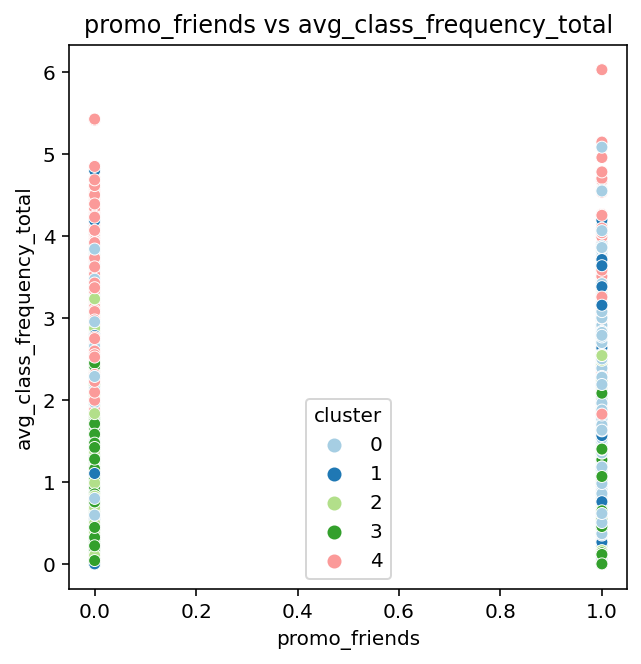

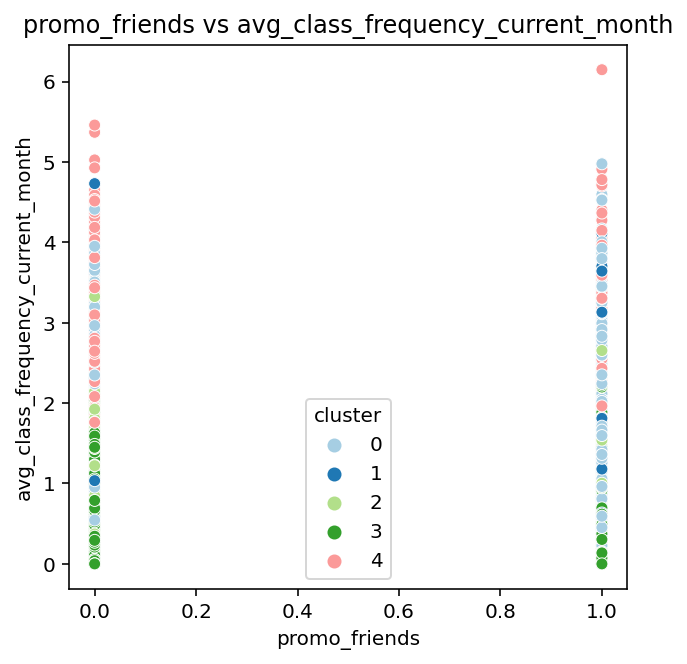

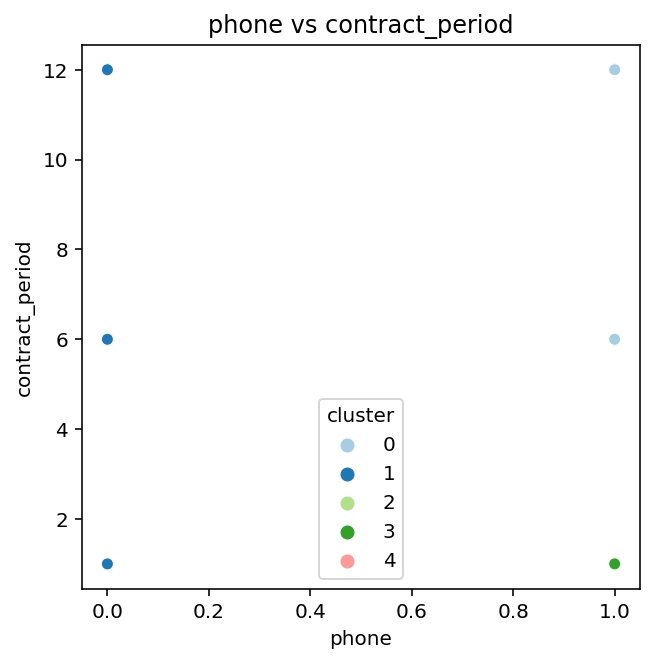

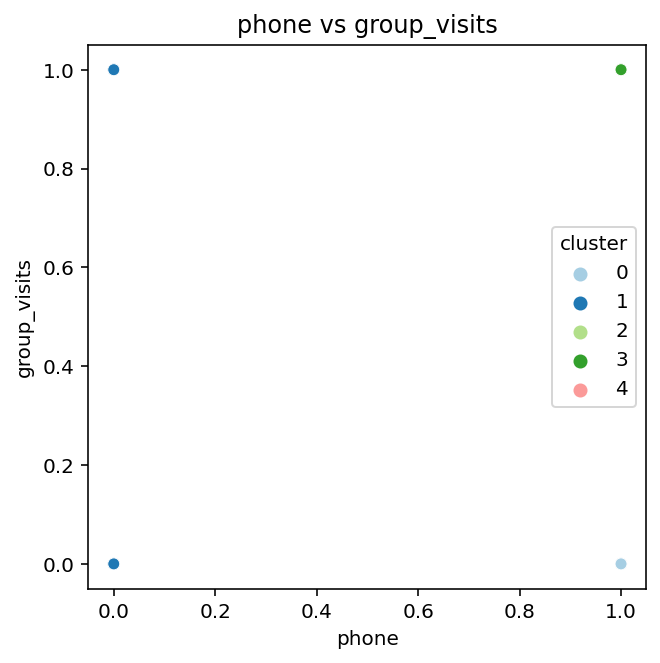

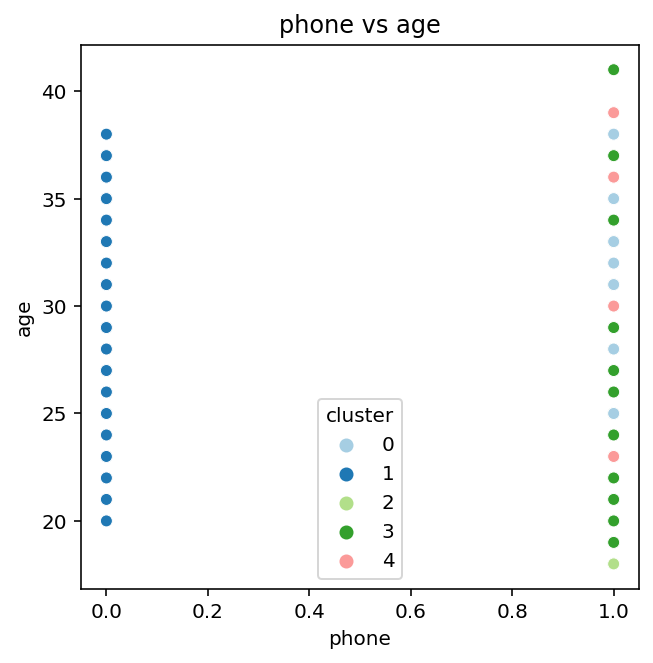

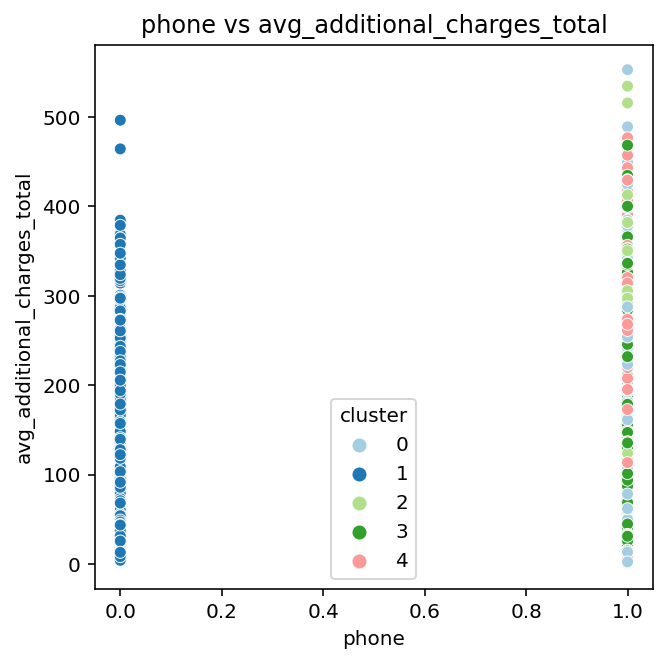

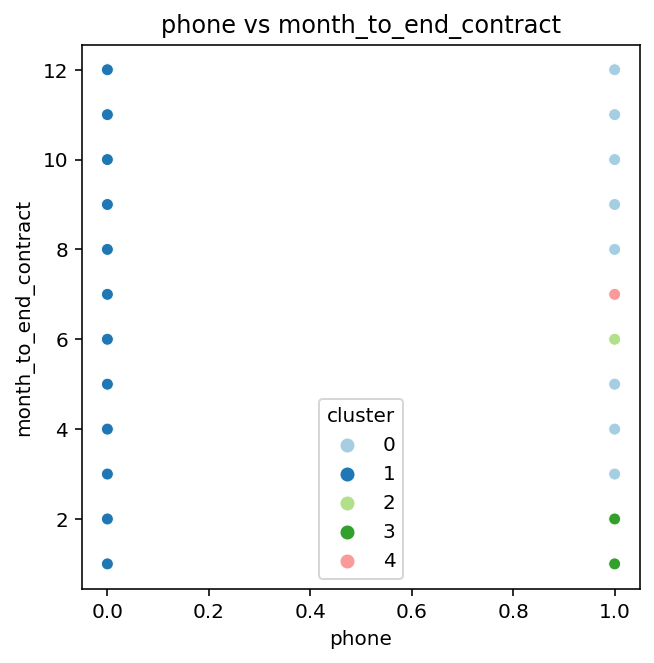

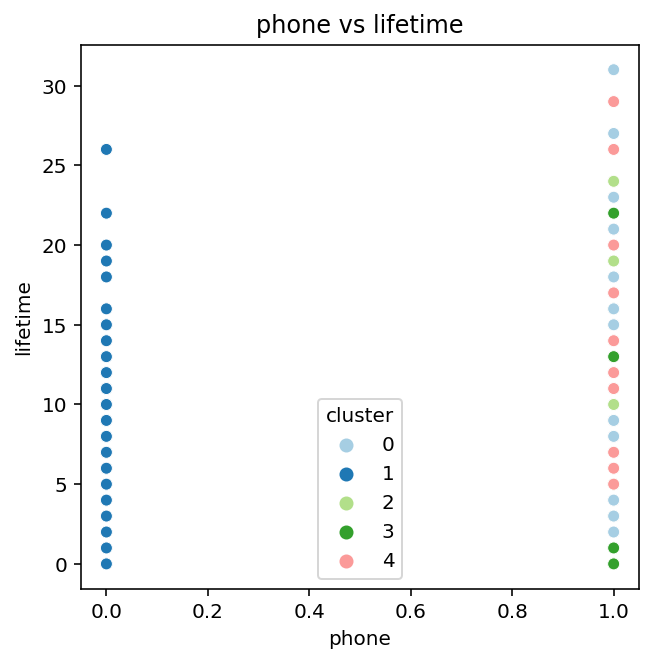

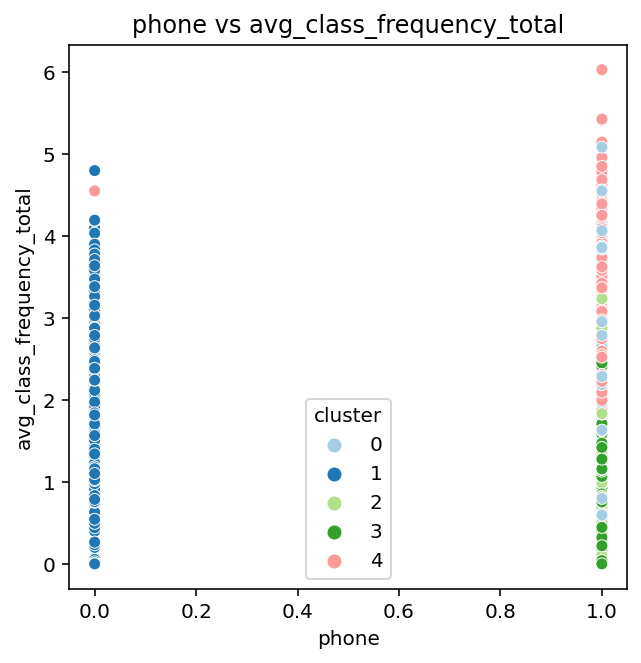

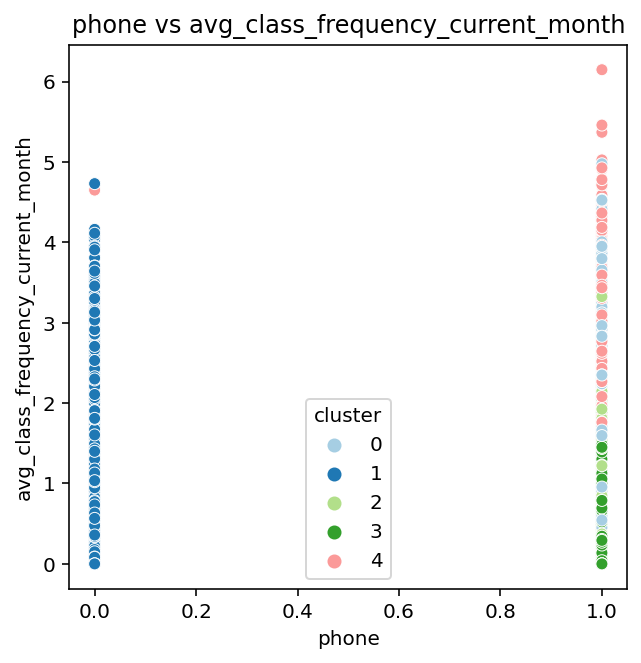

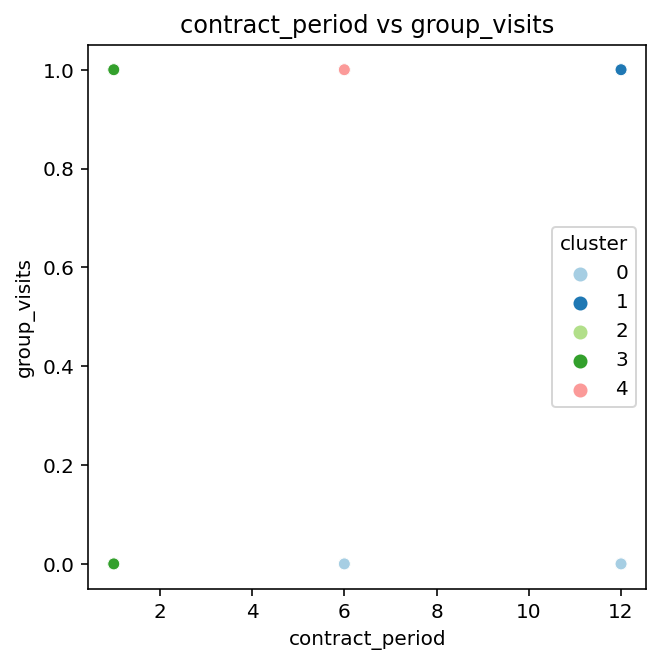

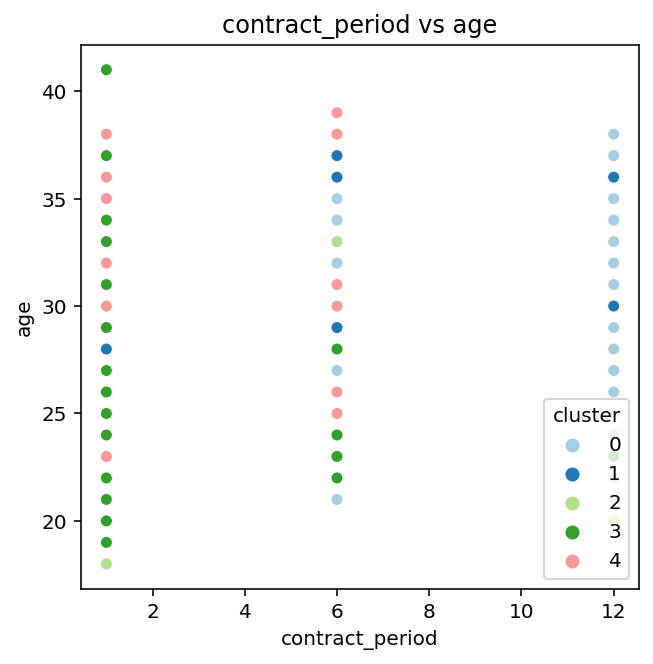

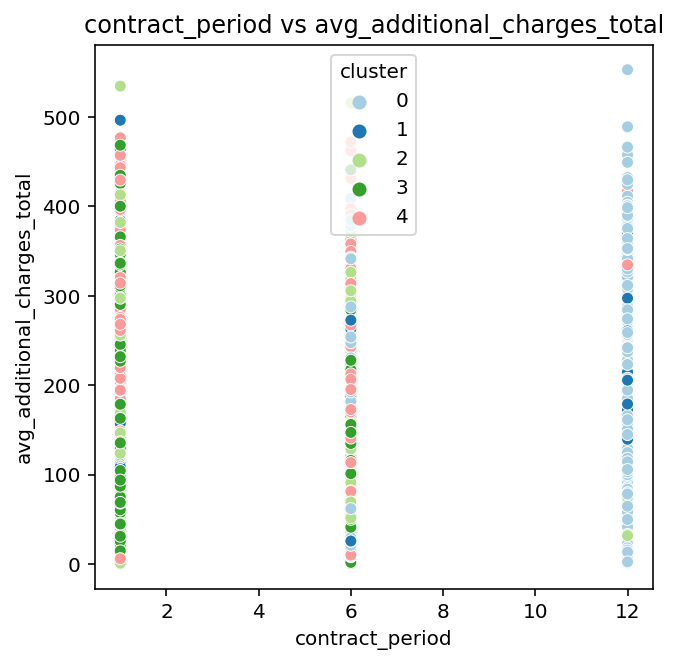

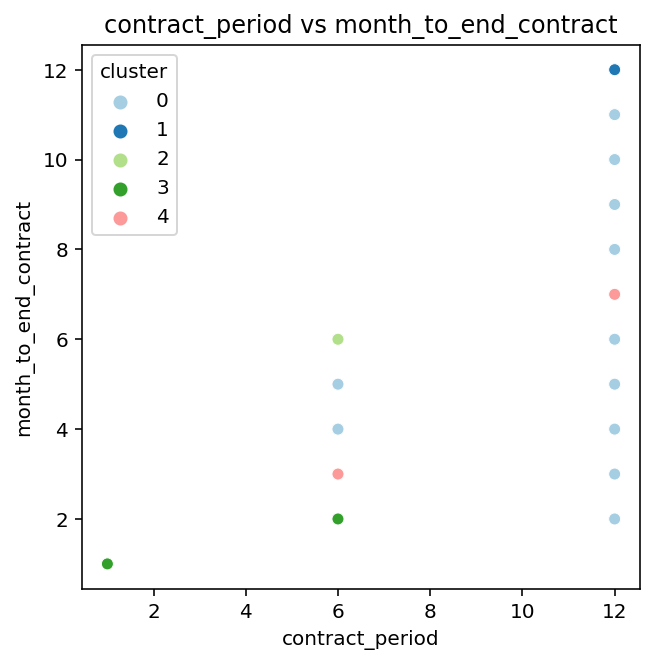

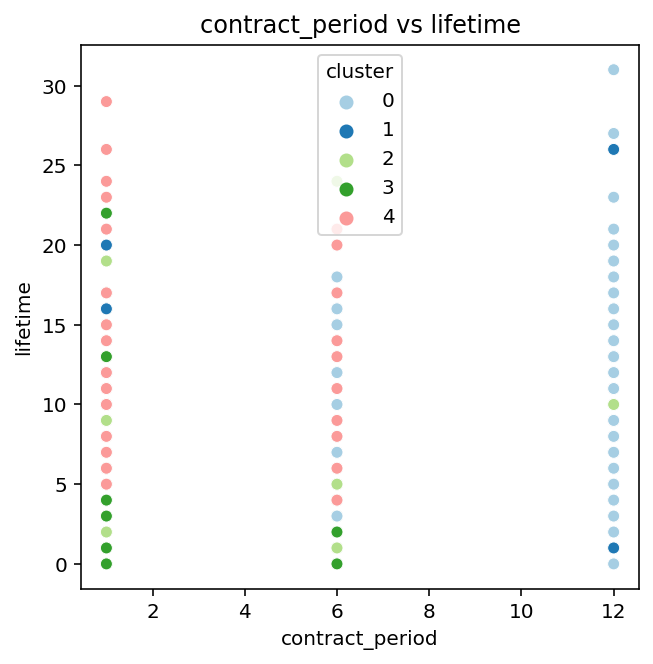

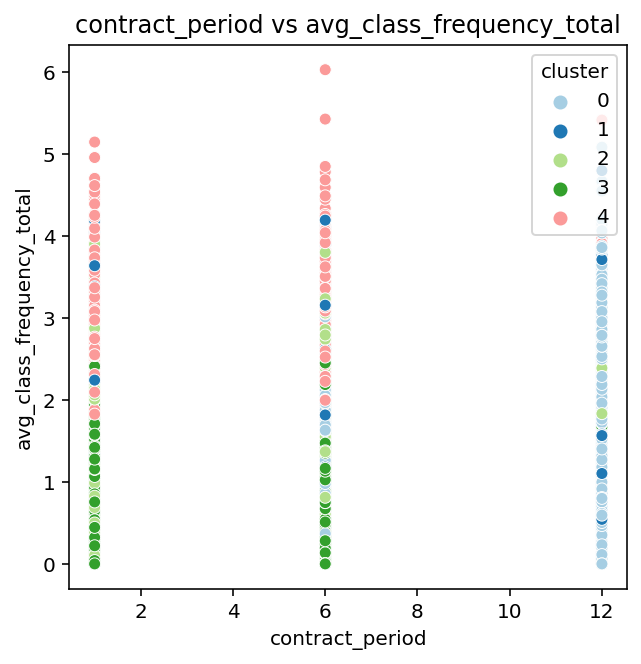

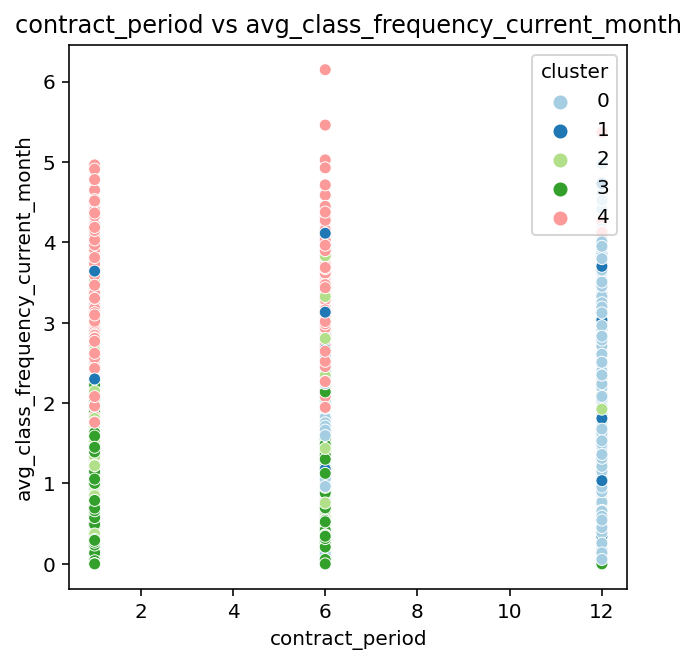

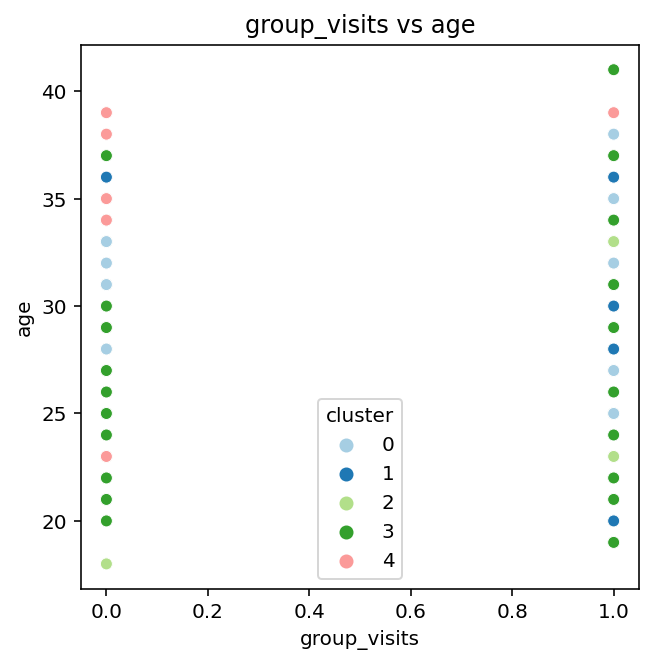

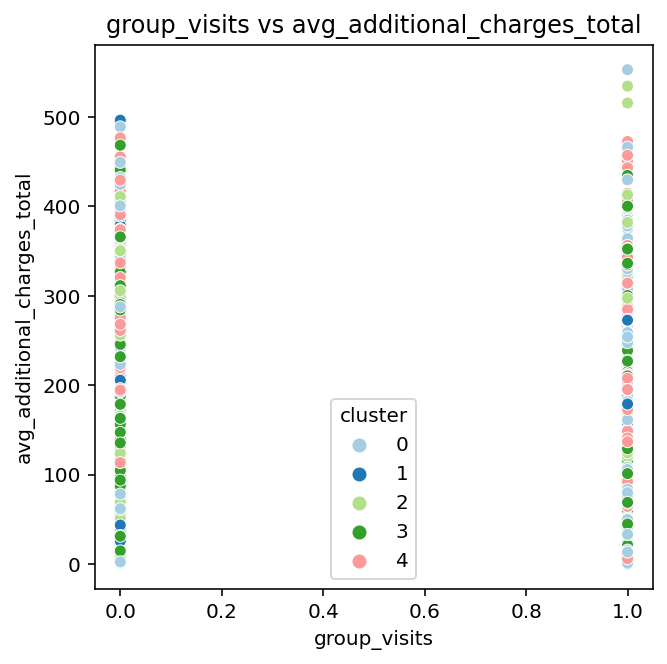

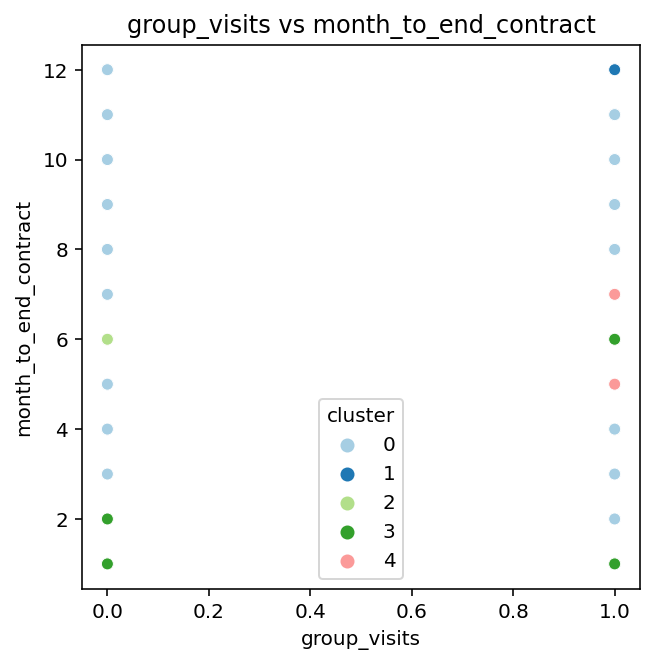

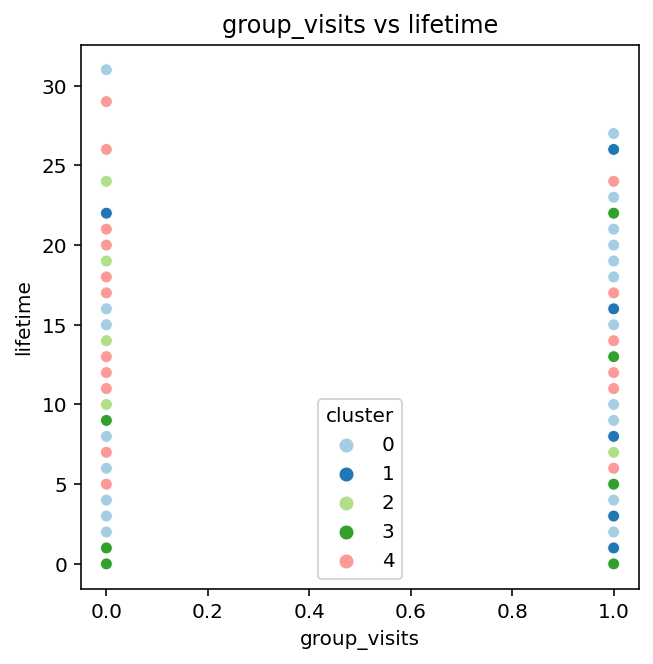

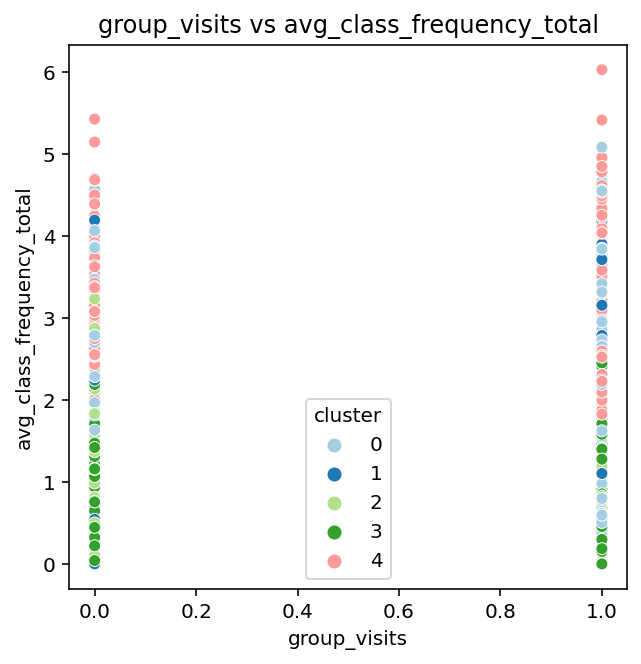

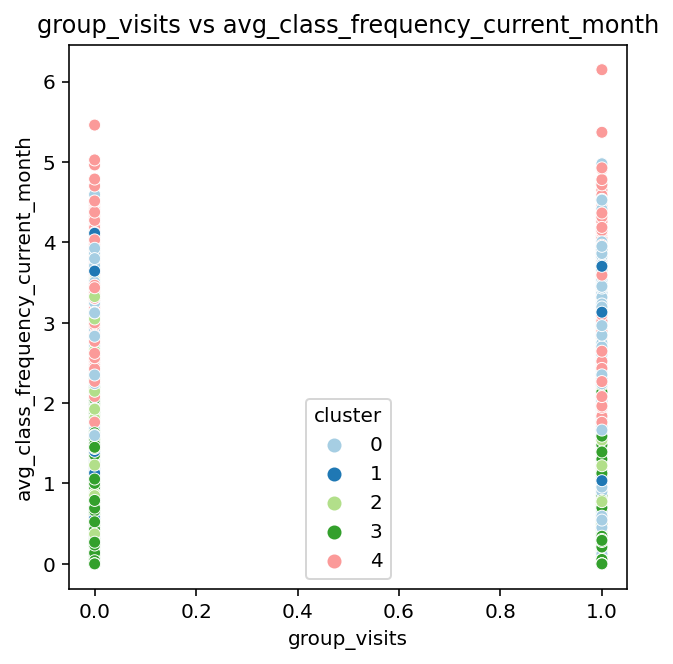

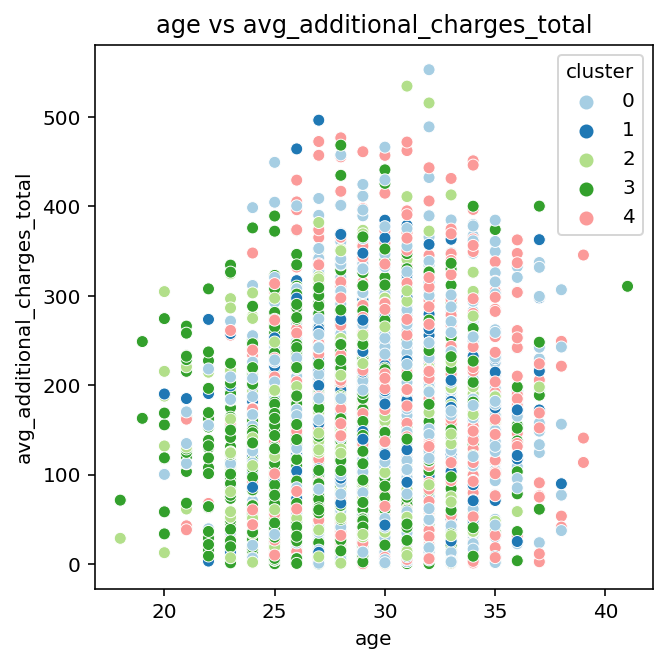

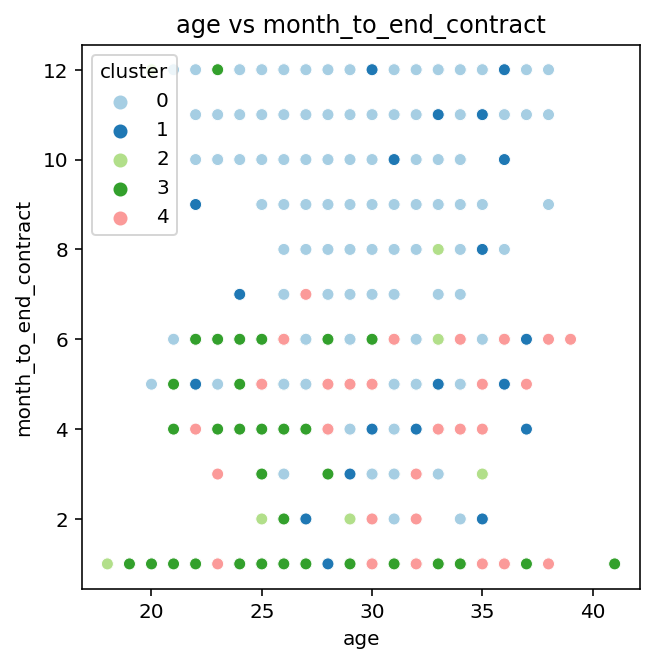

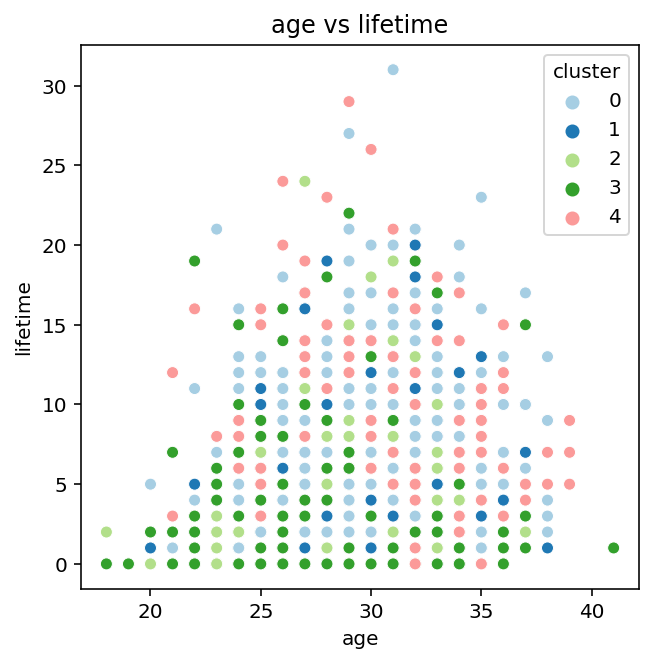

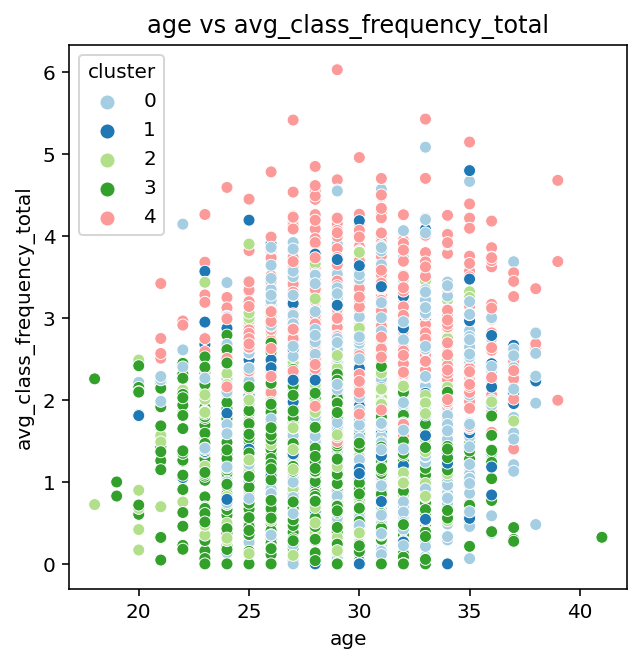

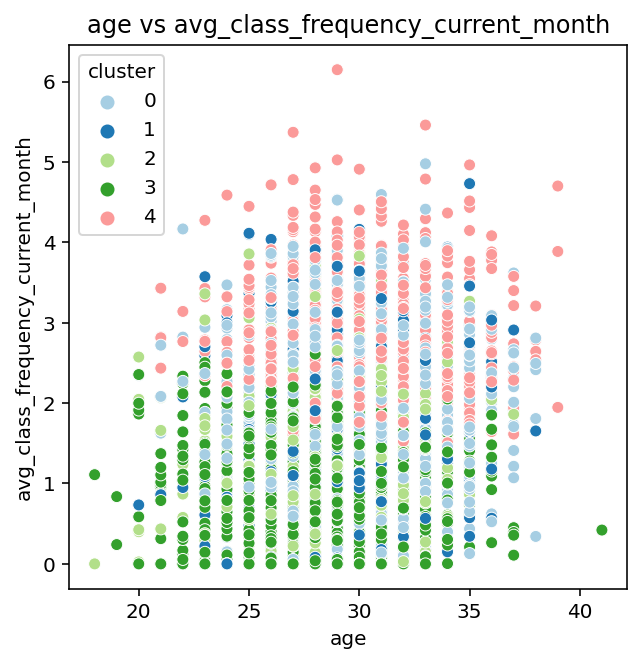

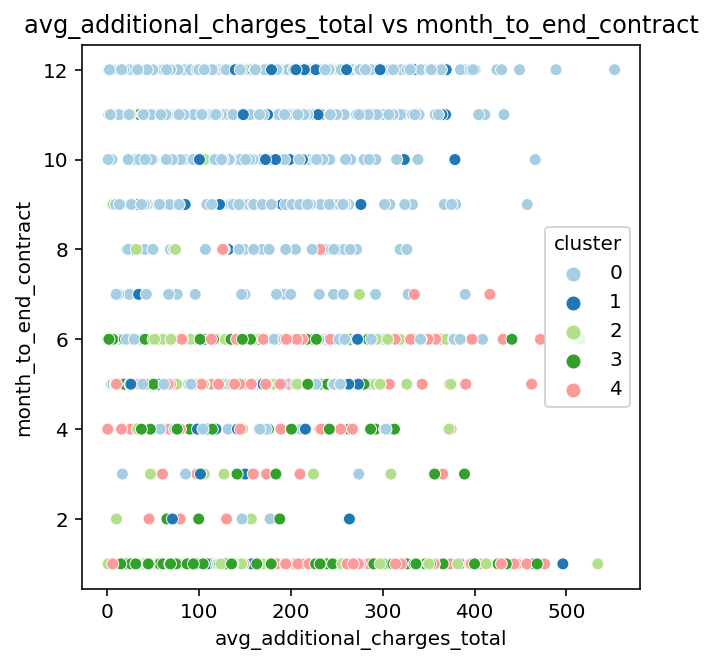

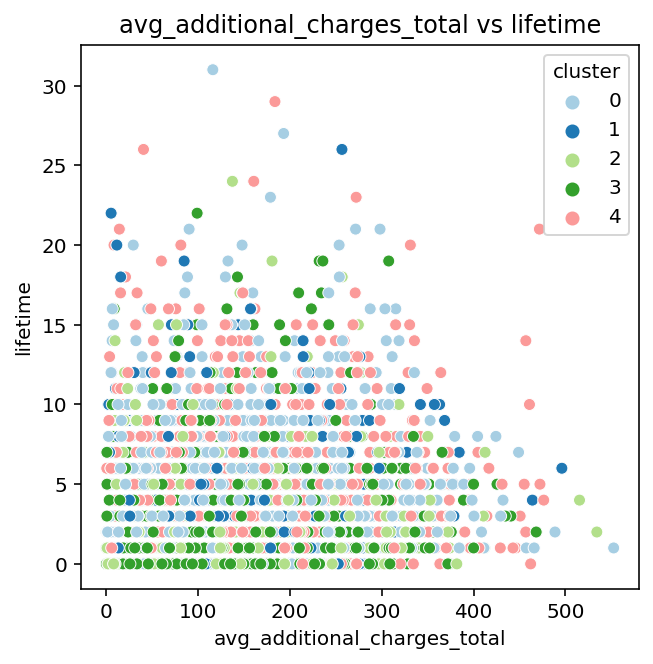

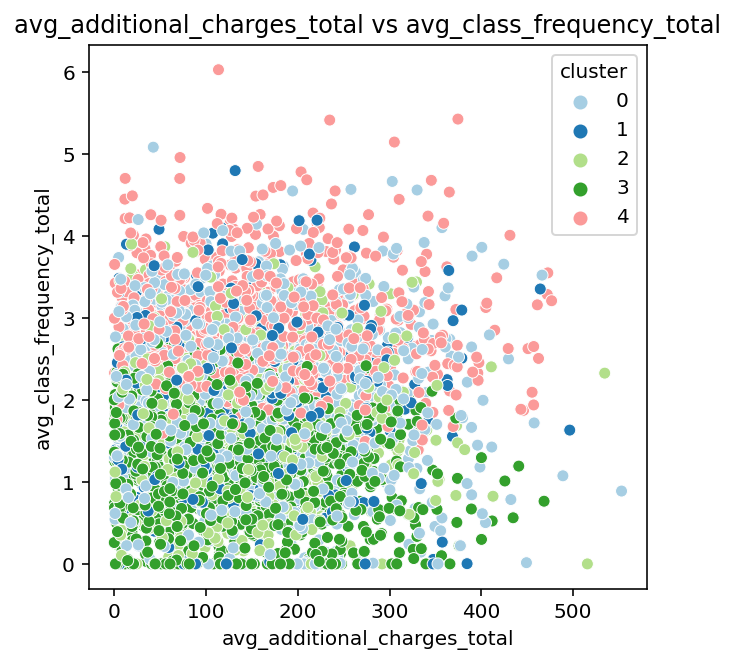

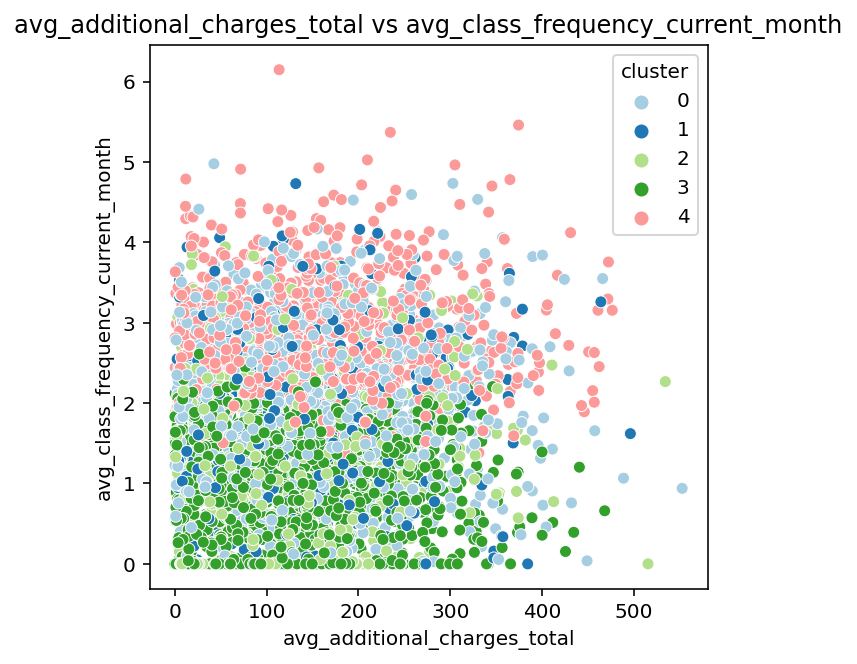

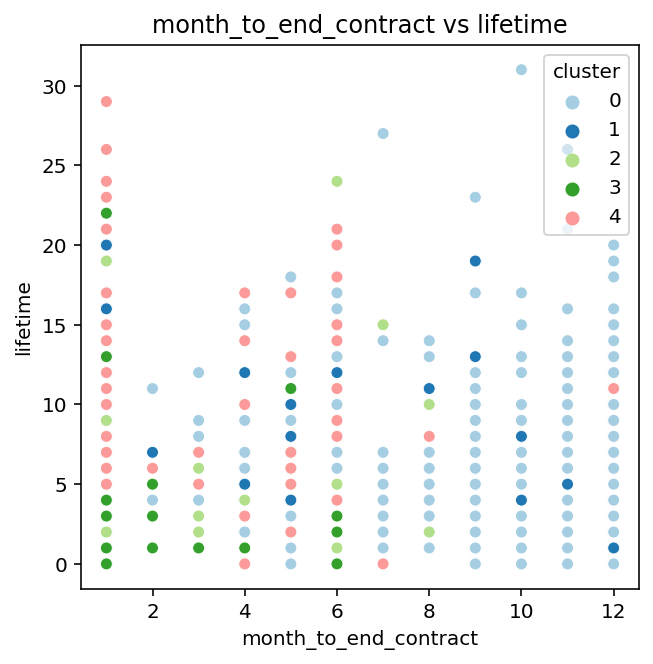

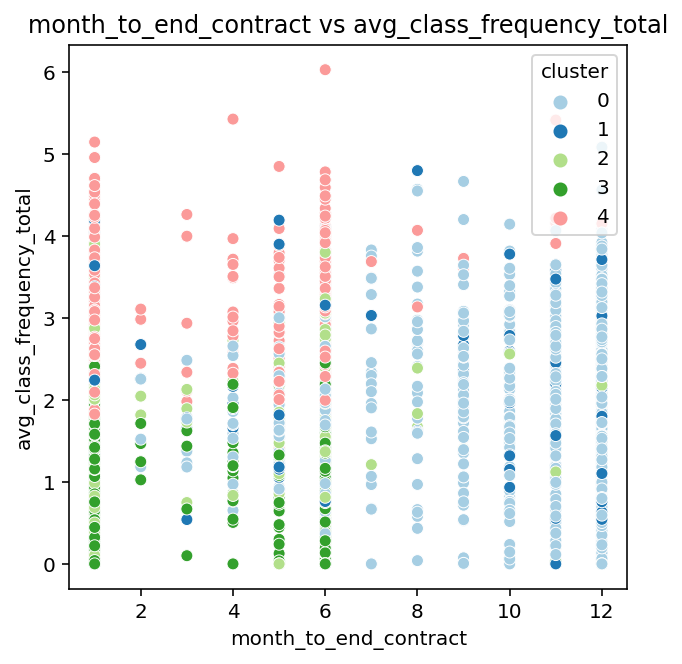

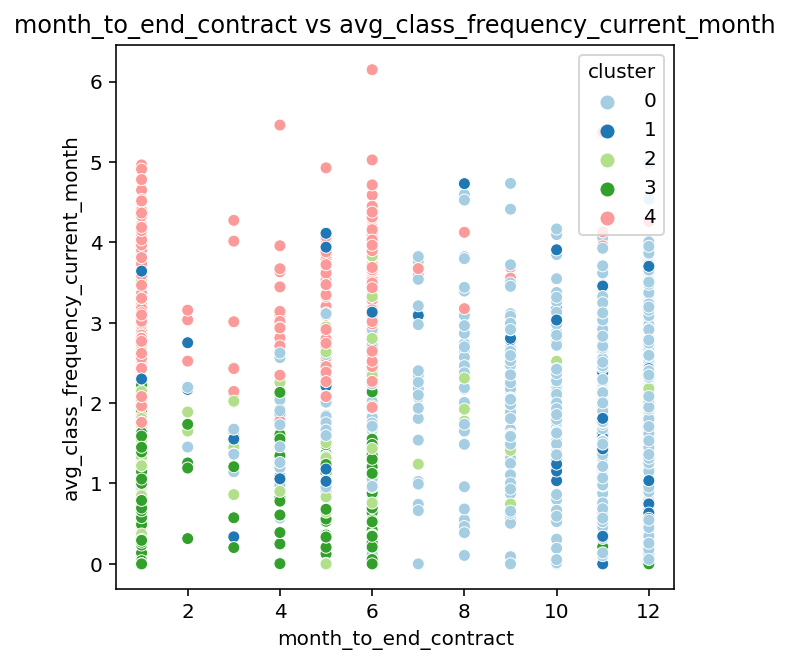

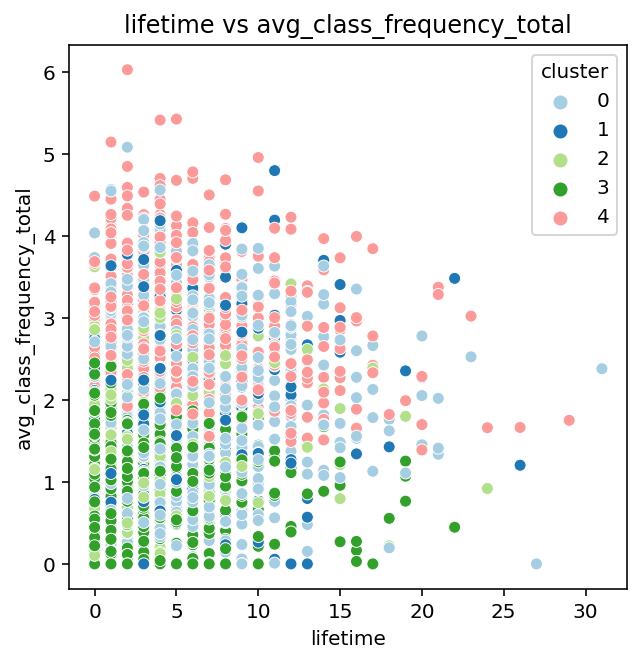

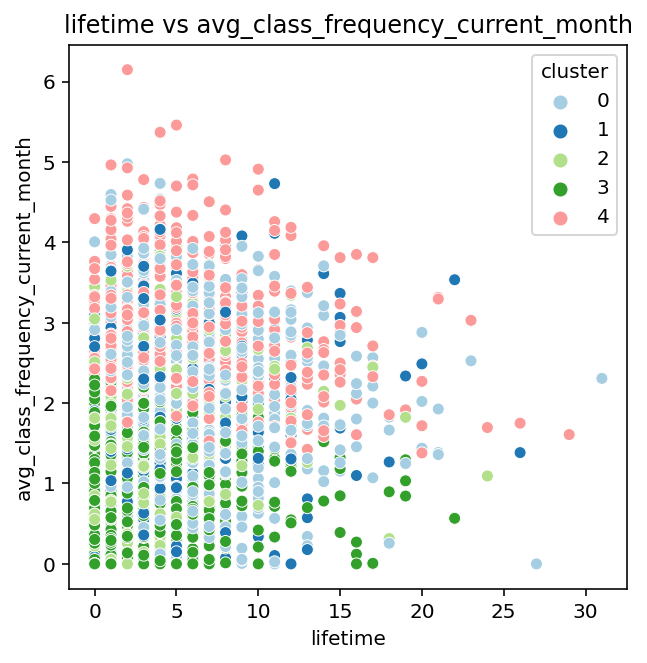

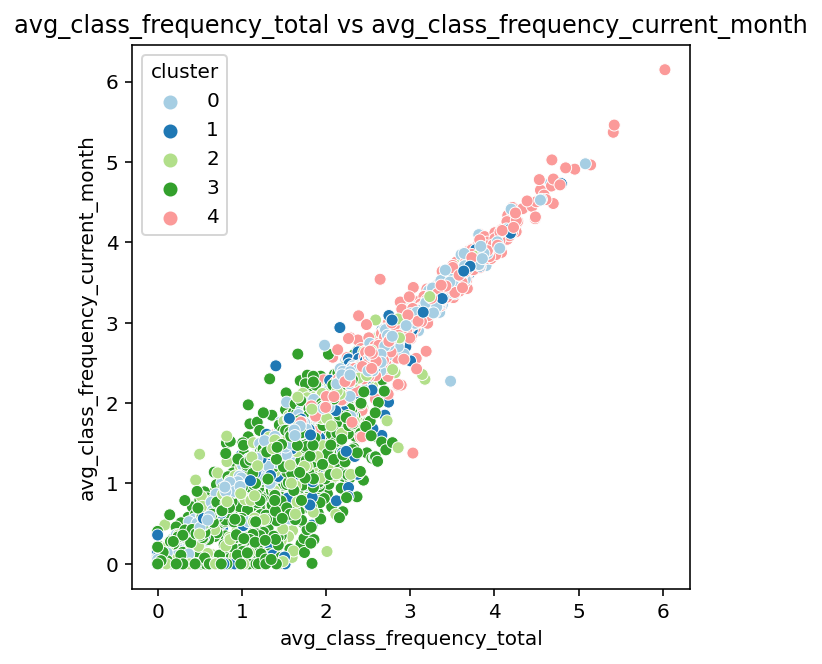

In [25]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(X.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(X, pair[0], pair[1], 'cluster')

Графики подтверждают, что у нас нет сильной разницы между кластерами по признакам, которые мы ранее обозначили как не важные, они довольно схожи между собой.

Хотя некоторые из них более показательны: например , довольно четкие границы у кластеров 1 и 4 на графике `avg_class_frequency_total`. А кластеры 3 и 4 находятся во многих парах далеко друг от друга.


Для каждого полученного кластера посчитаем долю оттока.

In [26]:
# создадим финальный датафрейм со показателями оттока и кластера 
df_final = X.merge(df)

# выведем средний показатель оттока для каждого кластера
df_final.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn')

churn
cluster       
0         0.03
4         0.07
1         0.27
2         0.44
3         0.51

Видим 3 группы кластеров:

1. Лояльные: 0 и 4 кластеры. Самые стабильные – показатель оттока у них самый низкий, близится к 0.

2. Рисковые: 1 кластер скорее лоялен, отток ниже 30% вероятности. 

3. Нелояльные: 2 кластер близится к 50%, поэтому стоит обратить на него особое внимание (прокачать лояльность). 3 кластер самый ненадежный – показатель оттока выше 50%.

Отдельно рассмотрим кластер 0, как эталон портрета "идеального клиента":

In [27]:
# выведем показатели для идеального клиента
df_final.query('cluster == 0').mean()

gender                                0.50
near_location                         0.96
partner                               0.78
promo_friends                         0.57
phone                                 1.00
contract_period                      10.89
group_visits                          0.54
age                                  29.98
avg_additional_charges_total        160.76
month_to_end_contract                 9.95
lifetime                              4.74
avg_class_frequency_total             1.98
avg_class_frequency_current_month     1.97
cluster                               0.00
churn                                 0.03
dtype: float64

**Портрет идеального клиента:**

- Может быть или мужчина, или женщина – в равной степени
- В 96% случаев клуб находится рядом с домом или работой
- В 78% случаев это сотрудник компании-партнёра клуба 
- 57% использовали промо-код от знакомого при оплате первого абонемента
- Оставляет номер телефона
- Покупает абонемента на более чем 10 месяцев
- 54% посещают групповые занятия
- Возраст 30 лет
- Ходит в клуб более 4 месяцев, 2 раза в неделю
- Средний чек за допуслуги $160

Рассмотрим три выделенных группы, чтобы вывести портрет клиента в каждой из них:

In [28]:
# выведем показатели для лояльных кластеров
df_final.query('cluster == 0 or cluster == 4').mean()

gender                                0.53
near_location                         0.97
partner                               0.59
promo_friends                         0.42
phone                                 1.00
contract_period                       7.16
group_visits                          0.51
age                                  30.05
avg_additional_charges_total        161.17
month_to_end_contract                 6.56
lifetime                              4.81
avg_class_frequency_total             2.38
avg_class_frequency_current_month     2.37
cluster                               1.81
churn                                 0.05
dtype: float64

**Портрет лояльного клиента:**

- Скорее мужчина, чем женщина (53% мужского пола)
- Клуб находится рядом с домом или работой
- 59% пришло по скидке от работодателя
- 42% пришло по скидке от друга
- Оставил номер телефона
- Средний период абонемента более 6 месяцев
- 51% посещает групповые занятия
- Возраст 30 лет
- Ходит в клуб более 4 месяцев, чаще 2 раз в неделю
- Средний чек за допуслуги $161

In [29]:
# выведем показатели для рискового кластера
df_final.query('cluster == 1').mean()

gender                                0.52
near_location                         0.86
partner                               0.47
promo_friends                         0.31
phone                                 0.00
contract_period                       4.79
group_visits                          0.43
age                                  29.30
avg_additional_charges_total        143.96
month_to_end_contract                 4.48
lifetime                              3.92
avg_class_frequency_total             1.85
avg_class_frequency_current_month     1.72
cluster                               1.00
churn                                 0.27
dtype: float64

**Портрет рискового клиента:**

- Скорее мужчина, чем женщина (52% мужского пола)
- Клуб находится рядом с домом или работой
- 47% пришло по скидке от работодателя
- 31% пришел по скидке от друга
- Не оставил номер телефона
- Средний период абонемента менее 6 месяцев
- 43% посещает групповые занятия
- Возраст 29 лет
- Ходит в клуб менее 4 месяцев, менее 2 раз в неделю
- Средний чек за допуслуги $144

In [30]:
# выведем показатели для нелояльных кластеров
df_final.query('cluster == 2 or cluster == 3').mean()

gender                                0.49
near_location                         0.71
partner                               0.38
promo_friends                         0.19
phone                                 1.00
contract_period                       2.06
group_visits                          0.31
age                                  28.26
avg_additional_charges_total        132.72
month_to_end_contract                 1.95
lifetime                              2.55
avg_class_frequency_total             1.37
avg_class_frequency_current_month     1.15
cluster                               2.71
churn                                 0.49
dtype: float64

**Портрет рискового клиента:**

- Скорее женщина, чем мужчина (51% женского пола)
- В 29% клуб находится далеко от дома или работы
- Всего 38% пришло по скидке от работодателя
- Всего 19% пришло по скидке от друга
- Оставили номер телефона
- Средний период абонемента всего 2 месяца
- 31% посещает групповые занятия
- Возраст 28 лет
- Ходит в клуб менее 4 месяцев, 1 раз в неделю
- Средний чек за допуслуги $132

### 4.4 Вывод по шагу

Мы провели кластеризацию пользователей и выделили группы клиентов, которые более склонны к оттоку. 

Разделив кластеры на 3 группы, мы выделили особенности, портреты клиентов, на основании которых можно составить рекомендации для отдела маркетинга.

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами


Мы выделили средние показатели по всему набору данных. Отталкиваясь от них, построили портрет среднего клиента данной сети фитнес-клубов:

- Средний пказатель оттока – 27% 
- Практически равное распределение по полу, а средний возраст клиента – 29 лет
- 85% клиентов предпочитает клуб рядом с домом или работой
- 49% – приходит по скидке от работодателя, 31% – по скидке «приведи друга»
- Групповые занятия посещает 41% клиентов
- Частота посещений: 1-2 раза в неделю (~1.8)
- Чек за дополнительные услуги: $147
- Срок с момента первого обращения в клуб: почти 4 месяца
- Контактный телефон оставляют 90% клиентов


Составив портреты групп на основании выделенных алгоритмом кластеров, разработали рекомендации для отдела маркетинга:

1. Демография: для привлечения подходят как мужчины, так и женщины в возрасте около 30 лет.
2. Геолокация: лояльнее те клиенты, у которых клуб находится рядом с домом или работой. Используйте таргетинг по геолокации, чтобы показывать рекламу конкретных клубов сети в радиусе 1-2 километров вокруг. Например, отличным вариантом будет реклама среди сотрудников ближайших офисных центров и жилых комплексов (таргетинг на "работает или живет в этом районе").
3. Бонусные программы: стимулируйте b2b-маркетинг, чтобы компании-партнеры приводили своих сотрудников. Эти клиенты самые лояльные, приносят больше всего денег и имеют самый длинный жизненный цикл клиента. Программа "приведи друга" также показывает хорошее повышение лояльности, мотивируйте действующих клиентов приводить друзей за взаимовыгодные бонусы.
4. Групповые занятия: мотивируйте клиентов посещать групповые занятия – они помогают увеличить лояльность, социальные контакты создают эффект соревнования и стимулируют продолжить общение в группе и остаться в клубе. Можно провести опрос, каких занятий не хватает нелояльным кластерам и попробовать поменять программу.
5. Частота занятий и абонемент: мотивируйте ходить 2 раза в неделю, по статистике такие клиенты остаются в клубе чаще. Это можно сделать например с помощью социальных мотиваций (групповые занятия 2 раза в неделю), делать рассылки о пользе фитнеса и новинках в клубе, организовывать какие-то челленджи, мотивирующие клиентов заниматься чаще. Самые выгодные для бизнеса абонементы – на 6 месяцев, сделайте их самыми выгодными и в глазах клиента – цена и условия по таким абонементам должны быть оптимальнами.
